In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import classification_models
from classification_models import GetLoader

In [2]:
#导入数据
factor_df=pd.read_csv("/data01/data_for_intern/factor_data_13_19.csv")
return_df=pd.read_csv("/data01/data_for_intern/return_data_13_19.csv")
return_label=return_df.drop(columns=['return_adj_d001','return_adj_d005','car_hs300_b30_d005'])
return_label['car_hs300_b30_d001']=(return_label['car_hs300_b30_d001']>=0)*1
#利用内连接方式合并数据
merged_factor_return = factor_df.merge(return_label,on=["stock_code","trade_date"],how="inner")
merged_factor_return

,stock_code,trade_date,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,...,factor_33,factor_34,factor_35,factor_36,factor_37,factor_38,factor_39,factor_40,factor_41,car_hs300_b30_d001
0,000001.SZ,2013-01-04,0.007966,0.024510,0.032475,-8.0,-0.114170,0.03,0.440203,-0.376429,...,0.790698,0.724551,0.812212,20.869800,43.5275,0.741100,0.680235,1.57469,3.43924,1
1,000001.SZ,2013-01-07,0.023154,0.006258,0.029412,-7.0,-0.589069,-0.31,0.129240,-0.840631,...,0.856688,0.909091,0.841909,18.507200,41.6409,0.741100,0.704779,1.47261,3.15030,0
2,000001.SZ,2013-01-08,0.004295,0.026994,0.031288,-5.0,-0.150607,0.30,0.957488,-0.160806,...,0.676724,0.727273,0.786972,20.082300,29.5337,0.605634,0.705782,1.48008,3.02077,0
3,000001.SZ,2013-01-09,0.003759,0.010025,0.013784,-3.0,-0.836842,0.14,0.802262,-0.532596,...,0.632231,0.642424,0.759596,8.662940,27.9438,0.536232,0.699468,1.47922,3.01475,0
4,000001.SZ,2013-01-10,0.015132,0.004414,0.019546,-1.0,-0.565992,-0.01,0.452223,-0.712085,...,0.629167,0.516667,0.628788,12.206900,27.2890,0.520000,0.690864,1.51058,3.06918,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5088415,603999.SH,2019-12-13,0.063063,0.007508,0.070571,-9.0,-0.875646,-0.32,0.138746,-0.876772,...,0.542857,0.855769,0.822900,1.148900,20.9302,0.029940,0.307711,1.14262,3.09775,1
5088416,603999.SH,2019-12-16,0.038682,0.007163,0.045845,-9.0,-0.880784,-0.18,0.306574,-0.751634,...,0.583333,0.884298,0.811730,0.782227,27.0718,0.187879,0.276938,1.04110,2.77682,0
5088417,603999.SH,2019-12-17,0.002821,0.016925,0.019746,-8.0,-0.854110,0.11,0.863933,-0.479172,...,0.654971,0.778761,0.839609,0.342224,29.0801,0.298013,0.260858,1.04584,2.66659,0
5088418,603999.SH,2019-12-18,0.010029,0.012894,0.022923,-7.0,-0.733061,0.04,0.511944,-0.716503,...,0.670659,0.736364,0.799807,0.391114,29.2537,0.324324,0.252109,1.07986,2.67018,1


In [3]:
#筛选日期节点,以15个交易日为界
date=[]
import datetime
date.append("2013-01-07")
i=0
while(i>-1):
    now=datetime.datetime.strptime(date[i], "%Y-%m-%d")
    if date[i]=="2019-12-02":
        break
    delta=datetime.timedelta(days=28)
    n_days=now+delta
    date.append(n_days.strftime('%Y-%m-%d'))
    i=i+1

In [4]:
date_dict={}
for i in range(len(date)-1):
    #print(i)
    temp_list=[]
    temp_list.append(date[i])
    now=datetime.datetime.strptime(date[i], "%Y-%m-%d")
    while(1):
        delta=datetime.timedelta(days=1)
        #print('k')
        now=now+delta
        #print('l')
        if now.strftime('%Y-%m-%d') == date[i+1]:
            break
        #print('o')
        temp_list.append(now.strftime('%Y-%m-%d'))
        #print(now.strftime('%Y-%m-%d'))
    date_dict[str(i)] = temp_list

In [5]:
valid_date_dict={}
for i in range(1,len(date)):
    #print(i)
    temp_list=[]
    temp_list.append(date[i])
    now=datetime.datetime.strptime(date[i], "%Y-%m-%d")
    k = 0
    while(1):
        delta=datetime.timedelta(days=1)
        #print('k')
        now=now+delta
        #print('l')
        if k>=14:
            break
        #print('o')
        temp_list.append(now.strftime('%Y-%m-%d'))
        #print(now.strftime('%Y-%m-%d'))
        k=k+1
    valid_date_dict[str(i-1)] = temp_list

In [6]:
valid_date_dict['0']

['2013-02-04',
 '2013-02-05',
 '2013-02-06',
 '2013-02-07',
 '2013-02-08',
 '2013-02-09',
 '2013-02-10',
 '2013-02-11',
 '2013-02-12',
 '2013-02-13',
 '2013-02-14',
 '2013-02-15',
 '2013-02-16',
 '2013-02-17',
 '2013-02-18']

In [7]:
df_train_dict={}
for i in range(len(date_dict)):
    df_train_dict[str(i)] = merged_factor_return[merged_factor_return['trade_date'].isin (date_dict[str(i)])]

In [8]:
df_valid_dict={}
for i in range(len(valid_date_dict)):
    df_valid_dict[str(i)] = merged_factor_return[merged_factor_return['trade_date'].isin (valid_date_dict[str(i)])]

In [9]:
from datetime import datetime
import roll_data
from roll_data import unroll_data

In [10]:
temp = df_valid_dict['1'].set_index(['trade_date', 'stock_code'])

In [11]:
index_list, data_list, label_list = unroll_data(temp, 100, 8, debug=False)

Filter large gap...
Time: 7.329
Unrolling Data...
Time: 4.762 s


In [12]:
len(index_list)

7407

In [13]:
label_list.shape

(7407,)

In [14]:
def nan_dele(index, data, label):
    a=data
    b=a.reshape([a.shape[0],a.shape[1]*a.shape[2]])
    c=b[~np.isnan(b).any(axis=1),:]
    data=c.reshape([c.shape[0], a.shape[1],a.shape[2]])
    d=label.reshape(-1,1)
    label=d[~np.isnan(b).any(axis=1),:].reshape(-1,)
    index=np.array(index)
    index=index[~np.isnan(b).any(axis=1),:]
    index=index.tolist()
    return index, data, label

In [15]:
class GetLoader(Dataset):
# 初始化函数，得到数据
    def __init__(self, data_num, data_root, data_label):
        self.num = data_num
        self.data = data_root
        self.label = data_label
    # index是根据batchsize划分数据后得到的索引，最后将data和对应的labels进行一起返回
    def __getitem__(self, index):
        num = self.num[index]
        data = self.data[index]
        labels = self.label[index]
        return num, data, labels
    # 该函数返回数据大小长度，目的是DataLoader方便划分，如果不知道大小，DataLoader会一执行错误
    def __len__(self):
        return len(self.data)

In [16]:
def load_data(index_list1, data_list1, label_list1,index_list2,data_list2, label_list2,batch_size):    
    train=GetLoader(index_list1, data_list1, label_list1)
    train_loader=torch.utils.data.DataLoader(dataset=train,batch_size=batch_size,shuffle=True,num_workers=0)
    valid=GetLoader(index_list2, data_list2, label_list2)
    valid_loader=torch.utils.data.DataLoader(dataset=valid,batch_size=len(data_list2),shuffle=False,num_workers=0)
    return train_loader, valid_loader

In [17]:
def predict_precision(model,images,labels,device,predict_type, softmax):
    model.eval()
    with torch.no_grad():
        correct=0
        total=0
        images=images.type(torch.FloatTensor)
        labels=labels.type(torch.FloatTensor)
        images=images.to(device)
        labels=labels.to(device)
        outputs=model(images)
        outputs=softmax(outputs)
        #print(outputs)
        num,predicted=torch.max(outputs.data,1)
        total+=sum(predicted)
        correct+=(sum(predicted*labels))
        print('precision of the model on the'+predict_type+'data: {}%'.format(100*correct/total))
    model.train()
    return num, 100*correct/total, predicted

In [18]:
def training(model, num_epochs, train_loader,valid_loader, loss_function, optimizer, device, softmax):
    total_step=0
    train_precision=[]
    valid_precision=[]
    for epoch in range(num_epochs):
        for data in train_loader:
            _, images, labels = data
            images=images.type(torch.FloatTensor)
            labels=labels.type(torch.FloatTensor)
            images=images.to(device)
            labels=labels.to(device)
            #forward pass
            outputs=model(images)
            loss=loss_function(outputs,labels.long())
        
            #Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_step+=1
            if (total_step) >= 8*1000:
                break
            if (total_step)%1000==0:
                #print("Epoch [{}/{}],step[{}] Loss:{:.4f}".format(epoch+1,num_epochs,total_step,loss.item()))
                _,train_pre,_=predict_precision(model,images,labels,device,predict_type='training',softmax=softmax)
                train_precision.append(train_pre)
                for _ , images, labels in valid_loader:
                    _,valid_pre,_=predict_precision(model,images,labels,device,predict_type='validation',softmax=softmax)
                valid_precision.append(valid_pre)
    plt.plot(train_precision,label="training precision")
    plt.plot(valid_precision,label="validation precision")
    plt.title("LSTM")
    plt.xlabel("1000*x training step")
    plt.ylabel("precision")
    plt.show()
    return train_precision, valid_precision, model

In [19]:
from classification_models import LSTM

In [20]:
def LSTM_rolling_window(df_train_dict, df_valid_dict):
    softmax = nn.Softmax(-1)
    result = {}
    for i in range(1, len(df_train_dict)):
        print("current i is",i)
        temp_df = df_train_dict[str(i)].set_index(['trade_date', 'stock_code'])
        train_index_list, train_data_list, train_label_list = unroll_data(temp_df, 100, 8, debug=False)

        temp_df = df_valid_dict[str(i)].set_index(['trade_date', 'stock_code'])        
        valid_index_list, valid_data_list, valid_label_list = unroll_data(temp_df, 100, 8, debug=False)    
        if len(valid_data_list) == 0:
            continue
        train_index_list, train_data_list, train_label_list = nan_dele(train_index_list, train_data_list, train_label_list)
        valid_index_list, valid_data_list, valid_label_list = nan_dele(valid_index_list, valid_data_list, valid_label_list)
        print(train_data_list.shape, valid_data_list.shape)
        sequence_length = 10  # 序列长度，将图像的每一列作为一个序列
        input_size = 42  # 输入数据的维度
        hidden_size = 64  # 隐藏层的size
        num_layers =  4 # 有多少层
        num_classes = 2
        batch_size = 256
        num_epochs = 200
        learning_rate = 0.001
        device = torch.device("cuda:1")
        
        train_loader, valid_loader = load_data(
            train_index_list, train_data_list, train_label_list,valid_index_list, valid_data_list, valid_label_list, batch_size)
        
        lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes,device=device)
        lstm.to(device)
        # Loss and Optimizer
        loss_function = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

        _, _, model = training(lstm, num_epochs, train_loader,valid_loader, loss_function, optimizer, device, softmax)
        
        for _, images, labels in valid_loader:
            num,valid_pre, predicted=predict_precision(model,images,labels,device,predict_type='validation',softmax=softmax)
        #num = softmax(num)
        print(num[0:100])
        result[str(i)] = valid_index_list, num, predicted, valid_label_list
    
    return result

current i is 1
Filter large gap...
Time: 6.728
Unrolling Data...
Time: 10.268 s
Filter large gap...
Time: 11.680
Unrolling Data...
Time: 8.184 s
(16318, 8, 42) (6998, 8, 42)
precision of the model on thetrainingdata: 67.9738540649414%
precision of the model on thevalidationdata: 44.97760772705078%
precision of the model on thetrainingdata: 66.96428680419922%
precision of the model on thevalidationdata: 45.136959075927734%
precision of the model on thetrainingdata: 76.72413635253906%
precision of the model on thevalidationdata: 44.80614471435547%
precision of the model on thetrainingdata: 83.49514770507812%
precision of the model on thevalidationdata: 44.55997085571289%
precision of the model on thetrainingdata: 88.28125%
precision of the model on thevalidationdata: 44.43699645996094%
precision of the model on thetrainingdata: 79.22077941894531%
precision of the model on thevalidationdata: 43.88954162597656%
precision of the model on thetrainingdata: 88.70967864990234%
precision of the 

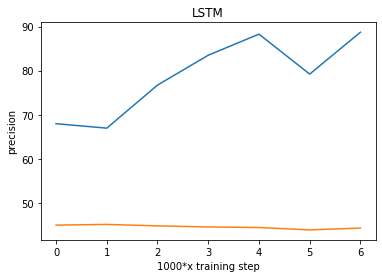

precision of the model on thevalidationdata: 45.0833625793457%
tensor([1.0000, 1.0000, 0.9614, 1.0000, 0.9993, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9263, 1.0000, 0.9916, 0.9708, 1.0000, 0.9999, 1.0000,
        0.9935, 0.6760, 0.7772, 1.0000, 0.9709, 1.0000, 1.0000, 0.9152, 0.9832,
        0.9930, 0.6218, 1.0000, 1.0000, 1.0000, 1.0000, 0.6216, 0.5088, 0.8399,
        0.8624, 1.0000, 1.0000, 0.9956, 1.0000, 0.9993, 0.8058, 0.9974, 0.8547,
        0.9979, 1.0000, 0.9988, 0.9921, 0.9938, 0.9941, 0.5088, 1.0000, 0.9999,
        1.0000, 0.6304, 0.9999, 1.0000, 1.0000, 0.9990, 0.6617, 0.9866, 0.9992,
        1.0000, 1.0000, 0.9983, 1.0000, 1.0000, 0.9973, 1.0000, 0.9955, 1.0000,
        1.0000, 1.0000, 0.9768, 1.0000, 0.8012, 0.5975, 0.9207, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.8568, 1.0000, 0.9818, 0.9709, 0.8050, 0.5440,
        1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 0.9714, 1.0000, 0.9128, 1.0000,
        1.0000], device='cuda:1')
current i is 2
Filter l

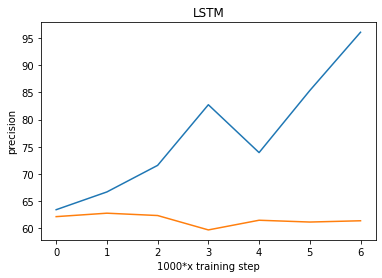

precision of the model on thevalidationdata: 61.606353759765625%
tensor([1.0000, 1.0000, 0.5634, 0.9938, 0.5544, 0.6139, 0.7488, 0.5493, 0.9691,
        0.9990, 0.5339, 1.0000, 0.5073, 0.5830, 0.9605, 0.7195, 0.9386, 0.8833,
        0.9992, 1.0000, 0.5336, 0.9081, 0.6621, 0.9980, 0.7929, 0.7840, 0.9478,
        1.0000, 0.8335, 0.9128, 0.9988, 0.8570, 0.5344, 0.5349, 0.5861, 0.6236,
        0.5049, 0.8388, 0.5413, 0.8785, 1.0000, 0.5673, 0.8159, 0.9748, 1.0000,
        0.9996, 0.5356, 0.8793, 0.8223, 1.0000, 1.0000, 1.0000, 0.5367, 1.0000,
        1.0000, 0.5075, 0.6815, 0.9998, 0.5419, 1.0000, 0.5551, 0.6106, 0.9196,
        0.5378, 0.9967, 0.6054, 0.9982, 0.9611, 1.0000, 1.0000, 0.6119, 1.0000,
        0.9447, 0.6255, 1.0000, 0.6984, 0.9397, 0.7918, 0.5041, 0.9997, 1.0000,
        0.9828, 0.9963, 0.5079, 0.5123, 0.9997, 1.0000, 0.9990, 0.5564, 0.6706,
        1.0000, 0.6507, 0.9997, 0.5078, 0.8830, 0.6113, 1.0000, 0.9951, 1.0000,
        0.9678], device='cuda:1')
current i is 3
Filter

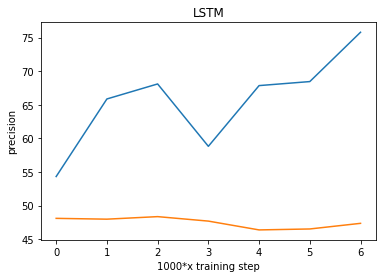

precision of the model on thevalidationdata: 47.3684196472168%
tensor([0.9908, 0.9999, 0.7585, 0.9968, 0.6211, 0.9979, 0.9793, 0.8390, 0.6781,
        0.6659, 1.0000, 0.9760, 0.9994, 0.8190, 0.9988, 1.0000, 0.7430, 0.5371,
        0.7758, 0.7996, 0.9994, 0.9974, 0.6653, 0.6150, 0.5645, 0.5617, 0.8505,
        0.9518, 1.0000, 0.6994, 0.7308, 0.9999, 1.0000, 0.5033, 0.6510, 0.7174,
        0.8753, 0.8698, 0.5821, 0.9986, 0.9820, 0.6657, 0.8152, 0.5326, 0.8611,
        0.8199, 1.0000, 1.0000, 0.9999, 0.5082, 0.8127, 0.7612, 0.9967, 0.5460,
        0.9690, 0.5413, 0.9658, 1.0000, 0.9986, 1.0000, 0.7118, 0.5528, 0.7686,
        0.6955, 0.8078, 0.6822, 0.9233, 0.8417, 0.7477, 0.6594, 0.5316, 0.5761,
        0.5423, 0.5295, 0.5434, 0.8689, 1.0000, 0.8393, 0.9577, 0.5144, 0.6752,
        0.5203, 0.5788, 0.5464, 0.5826, 0.9826, 0.9994, 0.5261, 0.6621, 0.5157,
        0.5780, 0.5678, 0.5738, 0.9998, 1.0000, 0.7275, 0.7823, 0.5848, 0.7427,
        0.5697], device='cuda:1')
current i is 5
Filter l

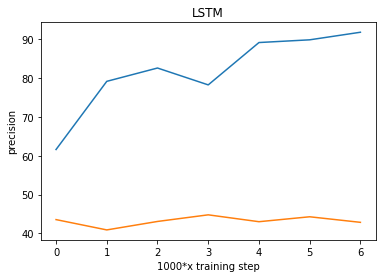

precision of the model on thevalidationdata: 40.5405387878418%
tensor([0.9990, 0.9737, 0.8410, 0.9998, 0.9612, 0.9809, 0.7038, 0.8964, 0.6759,
        1.0000, 0.9987, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 0.9888, 0.9992,
        1.0000, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000, 0.9324, 0.9999, 1.0000,
        1.0000, 0.9550, 1.0000, 0.9577, 0.9997, 0.9991, 0.6490, 0.9991, 1.0000,
        0.9999, 1.0000, 1.0000, 0.6026, 0.9092, 0.9992, 1.0000, 0.9976, 0.9997,
        0.9526, 0.9994, 0.9979, 1.0000, 0.6587, 1.0000, 0.8845, 0.9563, 1.0000,
        0.6415, 0.9998, 1.0000, 0.9526, 0.9984, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9944, 0.9999, 1.0000, 0.9994, 0.9952, 1.0000, 1.0000, 0.9988,
        0.9999, 0.9902, 1.0000, 1.0000, 1.0000, 0.9998, 0.9839, 0.9989, 1.0000,
        0.9912, 0.9993, 0.6979, 1.0000, 1.0000, 1.0000, 0.9970, 1.0000, 1.0000,
        0.9520, 1.0000, 0.9886, 1.0000, 0.9991, 0.9967, 0.9993, 1.0000, 1.0000,
        0.8637], device='cuda:1')
current i is 6
Filter l

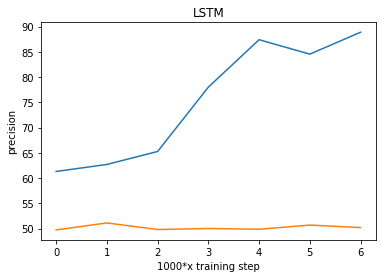

precision of the model on thevalidationdata: 49.22074890136719%
tensor([0.6059, 0.9274, 0.8788, 0.6964, 0.5832, 0.9921, 0.9997, 0.9991, 0.9991,
        0.9995, 0.9995, 0.6141, 0.9990, 1.0000, 0.9999, 0.9966, 0.9989, 0.8832,
        0.6987, 0.6395, 0.7081, 1.0000, 1.0000, 1.0000, 0.9983, 0.9984, 1.0000,
        1.0000, 0.9998, 1.0000, 0.9985, 0.9816, 0.9945, 0.7321, 0.6378, 0.5439,
        1.0000, 1.0000, 0.9999, 0.9079, 0.9996, 0.9993, 0.5567, 0.6250, 0.6303,
        0.9944, 1.0000, 1.0000, 1.0000, 1.0000, 0.9995, 0.7202, 0.6745, 0.5058,
        1.0000, 1.0000, 0.9971, 0.6657, 0.6375, 0.5842, 0.9853, 1.0000, 0.5965,
        1.0000, 0.5627, 1.0000, 0.5733, 0.6305, 0.6225, 0.9556, 0.9991, 0.9999,
        0.9973, 0.9999, 1.0000, 0.9968, 0.9848, 0.9101, 0.7459, 0.8965, 0.8844,
        0.6993, 0.6424, 0.9179, 0.5381, 0.7062, 0.5810, 0.8718, 0.5284, 0.6679,
        0.9579, 0.5533, 0.5307, 0.5668, 1.0000, 1.0000, 0.8403, 0.5664, 0.6239,
        0.9995], device='cuda:1')
current i is 7
Filter 

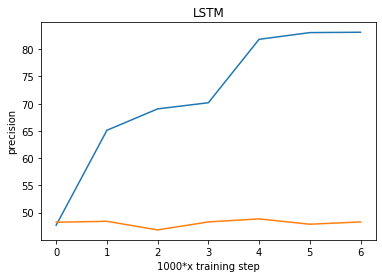

precision of the model on thevalidationdata: 48.08787536621094%
tensor([0.5814, 0.5820, 0.5793, 1.0000, 1.0000, 0.9997, 0.5209, 0.5965, 0.5219,
        0.5652, 0.5111, 0.5984, 0.6749, 0.7208, 0.6338, 0.9989, 0.6373, 1.0000,
        0.9989, 0.9952, 1.0000, 0.9995, 0.5841, 0.9813, 0.6443, 0.7969, 0.5337,
        0.9419, 1.0000, 0.9998, 0.6778, 0.9438, 0.8229, 1.0000, 0.9528, 1.0000,
        0.5284, 0.5857, 0.5567, 0.5957, 0.5253, 0.5281, 0.9985, 0.8533, 0.5453,
        0.8012, 0.9327, 0.9555, 0.5623, 0.5564, 0.5982, 0.6059, 0.5930, 0.5147,
        0.5424, 0.5733, 0.5842, 0.5842, 0.5841, 0.5841, 0.6955, 0.5254, 0.6444,
        0.7468, 0.7287, 0.5123, 0.5516, 0.5492, 0.5524, 0.5831, 0.5692, 0.7981,
        0.5703, 0.6014, 0.5525, 0.6045, 0.6091, 0.5890, 0.6252, 0.9999, 0.5112,
        0.6062, 0.5267, 0.5871, 0.7654, 0.9722, 0.6186, 0.6118, 0.5782, 0.5643,
        0.5441, 0.5368, 0.5234, 0.9975, 0.8255, 1.0000, 0.5687, 0.5806, 0.5842,
        0.5828], device='cuda:1')
current i is 8
Filter 

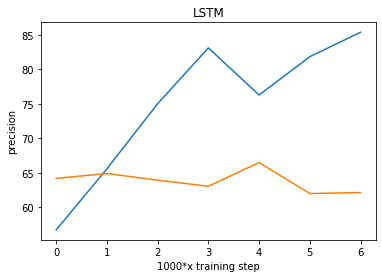

precision of the model on thevalidationdata: 63.7159538269043%
tensor([1.0000, 0.7090, 1.0000, 0.5844, 0.9331, 0.9992, 0.8379, 0.9843, 0.9972,
        0.9893, 0.6630, 1.0000, 0.6930, 0.9452, 0.8452, 0.5073, 0.6010, 0.5125,
        1.0000, 0.8266, 0.8246, 0.9981, 0.7379, 0.9999, 0.9926, 0.6747, 0.6337,
        0.9082, 0.7218, 0.9901, 0.9581, 0.9999, 1.0000, 1.0000, 0.8965, 1.0000,
        1.0000, 0.5116, 0.7038, 0.5492, 1.0000, 0.5914, 0.8401, 1.0000, 0.9242,
        0.9997, 1.0000, 0.7400, 0.6433, 0.9333, 0.9996, 0.6314, 0.7586, 0.9718,
        0.8137, 0.7013, 0.6677, 0.8221, 0.6699, 0.8106, 0.6014, 0.5687, 0.8560,
        0.6316, 0.9066, 0.8638, 0.7417, 0.9581, 1.0000, 0.9970, 0.9995, 0.9998,
        0.6356, 0.8006, 0.9805, 0.9619, 0.7465, 0.8369, 0.6550, 0.5294, 0.9838,
        0.6208, 0.9151, 0.9998, 1.0000, 0.5946, 0.9988, 0.6558, 0.9440, 0.8026,
        0.8275, 0.9770, 0.9750, 0.9991, 0.9807, 0.6671, 0.8112, 0.9942, 0.8312,
        0.9988], device='cuda:1')
current i is 9
Filter l

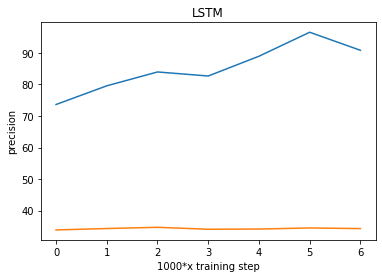

precision of the model on thevalidationdata: 34.609100341796875%
tensor([1.0000, 0.9689, 0.9997, 1.0000, 0.9917, 1.0000, 0.7711, 0.8758, 0.8230,
        0.7046, 0.9756, 0.9796, 0.6420, 0.9993, 0.9959, 0.6884, 0.6487, 0.9963,
        0.9999, 0.9942, 1.0000, 0.9962, 0.6983, 0.9538, 1.0000, 1.0000, 0.6852,
        0.5124, 0.9560, 0.9999, 1.0000, 1.0000, 1.0000, 0.9995, 0.8675, 0.9952,
        0.8216, 0.9758, 1.0000, 0.9709, 0.9998, 1.0000, 1.0000, 0.9926, 1.0000,
        0.9353, 0.9823, 0.9998, 1.0000, 0.7784, 1.0000, 1.0000, 0.9999, 0.9847,
        0.9847, 0.6860, 0.6399, 1.0000, 0.9959, 0.9452, 0.7195, 0.9423, 0.5514,
        0.9840, 0.9659, 0.9996, 0.9999, 1.0000, 0.9951, 0.9495, 0.9193, 0.9978,
        0.5973, 1.0000, 1.0000, 0.9998, 0.9982, 1.0000, 1.0000, 0.9412, 0.6966,
        0.9927, 1.0000, 1.0000, 1.0000, 0.9118, 0.5009, 0.9999, 0.9999, 0.9393,
        1.0000, 1.0000, 0.9994, 0.9821, 0.7586, 0.9999, 1.0000, 0.9832, 1.0000,
        1.0000], device='cuda:1')
current i is 10
Filte

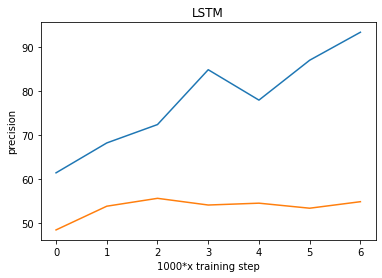

precision of the model on thevalidationdata: 55.38761520385742%
tensor([0.9843, 1.0000, 0.9999, 0.7187, 1.0000, 0.9999, 0.8781, 0.6592, 0.9903,
        1.0000, 0.8607, 0.9307, 0.5783, 0.5225, 0.5974, 1.0000, 1.0000, 0.6607,
        0.9380, 0.9993, 0.9961, 0.9992, 0.9541, 0.6556, 0.9942, 0.5494, 0.9293,
        0.9995, 1.0000, 0.9969, 0.9979, 1.0000, 1.0000, 0.7208, 0.9955, 0.7607,
        0.9754, 0.6871, 0.9717, 0.8893, 0.9399, 0.9991, 1.0000, 0.6816, 0.5405,
        0.9775, 0.6268, 0.5464, 1.0000, 0.6872, 0.6993, 0.6470, 0.7094, 0.5775,
        0.5733, 0.8697, 0.6729, 1.0000, 1.0000, 0.5734, 0.8278, 0.6873, 0.5962,
        1.0000, 1.0000, 1.0000, 0.9231, 0.9991, 0.9988, 0.8596, 0.5838, 0.7989,
        0.6228, 0.6492, 0.7531, 0.7260, 0.5779, 0.5476, 0.9998, 0.8400, 1.0000,
        0.9978, 0.9325, 0.8379, 1.0000, 0.9990, 0.9357, 0.6533, 0.6011, 0.5687,
        0.9659, 0.9751, 1.0000, 0.9938, 0.9998, 0.9561, 0.9998, 0.5015, 0.9726,
        0.9751], device='cuda:1')
current i is 11
Filter

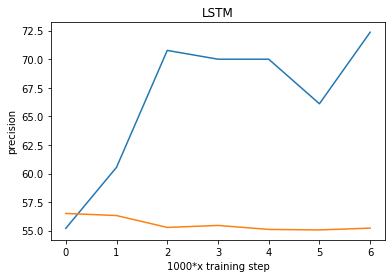

precision of the model on thevalidationdata: 55.21677017211914%
tensor([0.7853, 0.9579, 0.8111, 0.9673, 0.9999, 0.9988, 1.0000, 0.9935, 0.9991,
        0.9960, 0.9981, 0.9994, 1.0000, 1.0000, 1.0000, 0.7347, 1.0000, 0.9988,
        0.9590, 0.9063, 0.9999, 0.9775, 0.9957, 0.9953, 0.6776, 0.6367, 0.6481,
        0.9999, 0.9993, 0.9991, 0.9764, 1.0000, 0.9999, 0.5173, 0.9931, 0.9999,
        1.0000, 0.8491, 1.0000, 0.5743, 0.7946, 0.7906, 0.7020, 0.6101, 0.7316,
        0.9946, 0.9708, 0.8198, 0.9999, 1.0000, 1.0000, 0.6467, 0.6818, 0.6737,
        0.9999, 0.9999, 0.9958, 0.6150, 0.8512, 0.5965, 0.5165, 0.6896, 0.6742,
        0.6600, 0.9762, 0.9999, 0.6786, 0.5560, 0.5299, 0.6921, 0.6184, 0.5448,
        0.7950, 0.6921, 0.6532, 1.0000, 0.9992, 0.9878, 0.9997, 0.9998, 0.9984,
        0.8566, 0.9959, 0.9988, 0.6090, 0.5638, 0.5048, 0.9998, 0.7665, 0.6287,
        0.9997, 0.9995, 1.0000, 0.9827, 0.5757, 0.9828, 0.9921, 1.0000, 1.0000,
        0.9987], device='cuda:1')
current i is 12
Filter

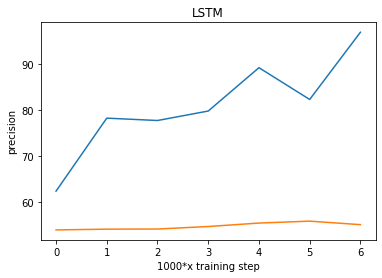

precision of the model on thevalidationdata: 55.62604522705078%
tensor([0.9351, 1.0000, 0.7996, 0.9993, 1.0000, 1.0000, 0.6302, 0.6336, 0.9377,
        0.9745, 0.6209, 1.0000, 0.9699, 0.9792, 1.0000, 0.5152, 0.5754, 0.7272,
        0.9848, 0.6526, 0.8616, 1.0000, 0.5968, 0.9997, 0.9997, 1.0000, 1.0000,
        0.8967, 0.9986, 0.9633, 0.9999, 0.9995, 1.0000, 0.9515, 1.0000, 0.9998,
        1.0000, 0.9965, 0.6819, 0.6263, 0.9721, 0.5785, 1.0000, 0.8166, 1.0000,
        0.9932, 0.9828, 0.9925, 0.6065, 0.5786, 0.5621, 0.7793, 0.9887, 1.0000,
        0.9992, 1.0000, 0.9999, 0.9136, 0.6982, 1.0000, 1.0000, 1.0000, 0.9647,
        0.9946, 0.9630, 1.0000, 1.0000, 1.0000, 0.6033, 0.7116, 0.7081, 1.0000,
        0.9670, 1.0000, 1.0000, 0.6077, 1.0000, 0.9765, 0.9988, 0.9167, 1.0000,
        0.9945, 0.9923, 0.9981, 0.9991, 0.9998, 1.0000, 0.9998, 1.0000, 0.8615,
        0.8685, 1.0000, 1.0000, 0.9270, 0.9553, 0.9999, 0.9999, 0.5374, 1.0000,
        0.8036], device='cuda:1')
current i is 13
Filter

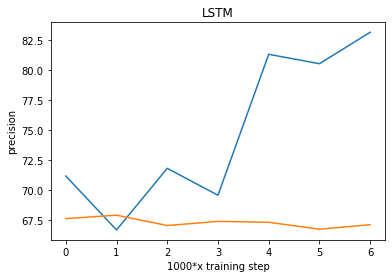

precision of the model on thevalidationdata: 67.07080841064453%
tensor([1.0000, 0.9354, 1.0000, 0.9814, 0.5885, 0.9245, 0.9587, 1.0000, 1.0000,
        1.0000, 0.9978, 1.0000, 1.0000, 0.9573, 0.9775, 0.7001, 1.0000, 0.9617,
        0.9981, 0.9791, 0.5451, 1.0000, 0.9999, 1.0000, 0.9847, 1.0000, 1.0000,
        0.7169, 0.9911, 1.0000, 1.0000, 0.9993, 0.9979, 1.0000, 1.0000, 1.0000,
        0.8112, 0.7177, 0.8229, 0.9973, 1.0000, 0.9565, 1.0000, 0.9993, 0.9997,
        0.9999, 0.5950, 0.9812, 0.9581, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9999, 0.9974, 1.0000, 0.9910, 1.0000, 0.5154, 0.7342, 0.5617,
        0.9986, 0.9999, 0.8941, 0.5764, 0.8321, 0.6359, 0.9993, 1.0000, 0.9858,
        0.9910, 0.9999, 1.0000, 1.0000, 0.8064, 1.0000, 0.9400, 0.8368, 0.8152,
        0.9984, 1.0000, 0.8611, 0.7837, 0.8433, 1.0000, 0.7324, 0.8741, 0.5768,
        0.5579, 0.5352, 0.8130, 1.0000, 1.0000, 0.9993, 0.9999, 0.6746, 1.0000,
        1.0000], device='cuda:1')
current i is 15
Filter

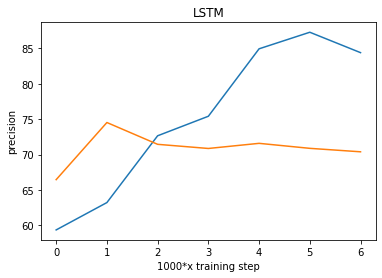

precision of the model on thevalidationdata: 69.59818267822266%
tensor([0.5798, 0.5867, 0.9118, 0.9737, 0.9828, 0.8819, 0.9884, 0.5627, 0.8212,
        0.6295, 0.9993, 0.9945, 0.9864, 1.0000, 1.0000, 0.9683, 0.9990, 0.9899,
        0.6556, 0.8666, 0.5915, 0.5862, 0.9772, 0.5402, 0.7126, 0.7968, 0.5715,
        0.5425, 1.0000, 0.9999, 0.5959, 0.5206, 0.9584, 0.9589, 0.9076, 0.9694,
        0.7255, 0.9058, 0.8390, 0.5506, 0.5899, 0.6505, 0.5970, 0.5691, 0.7504,
        0.8292, 1.0000, 1.0000, 0.5394, 0.6985, 0.6958, 0.5634, 0.5933, 0.5016,
        1.0000, 0.6951, 0.6612, 0.6266, 1.0000, 0.9975, 0.5348, 0.6246, 0.5747,
        0.5378, 0.6227, 0.5596, 0.9887, 0.6352, 0.5980, 0.5272, 0.5954, 0.5783,
        0.5348, 1.0000, 0.9891, 0.9991, 0.5540, 0.8306, 0.5894, 0.6315, 0.9198,
        1.0000, 0.9957, 0.9889, 0.9817, 0.9888, 0.9973, 0.5900, 0.5895, 0.5895,
        0.5894, 0.6394, 0.6030, 0.8698, 0.5105, 0.9751, 0.9723, 0.9924, 1.0000,
        0.5902], device='cuda:1')
current i is 16
Filter

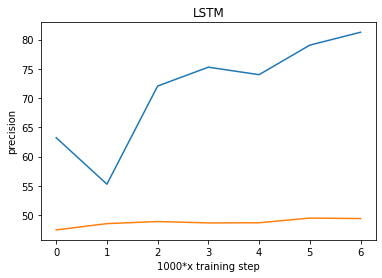

precision of the model on thevalidationdata: 48.594024658203125%
tensor([1.0000, 0.9911, 1.0000, 1.0000, 1.0000, 0.9947, 0.9998, 1.0000, 1.0000,
        1.0000, 1.0000, 0.5049, 1.0000, 1.0000, 1.0000, 0.9987, 1.0000, 0.5569,
        1.0000, 0.9998, 0.9279, 0.6823, 0.9999, 1.0000, 0.9993, 0.9678, 1.0000,
        1.0000, 0.9998, 1.0000, 0.9976, 0.6038, 1.0000, 0.7786, 1.0000, 1.0000,
        0.6299, 1.0000, 0.5775, 1.0000, 1.0000, 0.9613, 0.6987, 1.0000, 0.9999,
        1.0000, 0.5557, 0.7002, 1.0000, 0.9969, 1.0000, 1.0000, 0.9996, 1.0000,
        1.0000, 0.9747, 1.0000, 1.0000, 0.9999, 0.9880, 0.9990, 1.0000, 0.8073,
        1.0000, 0.9995, 0.8481, 1.0000, 1.0000, 1.0000, 1.0000, 0.9841, 1.0000,
        0.9999, 0.9998, 0.5973, 1.0000, 0.9439, 0.9570, 0.9812, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9830, 1.0000, 1.0000, 1.0000, 0.9960, 0.9962,
        0.8740, 0.9998, 1.0000, 0.8862, 1.0000, 1.0000, 1.0000, 0.5529, 1.0000,
        0.9999], device='cuda:1')
current i is 17
Filte

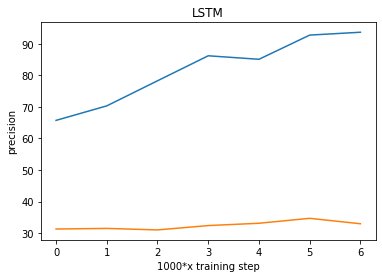

precision of the model on thevalidationdata: 33.666831970214844%
tensor([0.7246, 0.6332, 0.9177, 1.0000, 0.5086, 0.6058, 0.7072, 0.9990, 0.6818,
        0.5777, 1.0000, 0.7811, 0.9814, 0.9932, 0.5186, 0.5459, 1.0000, 0.9792,
        0.9999, 1.0000, 0.8598, 0.8943, 0.9993, 0.9187, 0.7885, 0.7087, 0.9996,
        0.9982, 0.6358, 0.5395, 0.5466, 0.5319, 1.0000, 0.5073, 1.0000, 0.9748,
        0.5464, 0.6323, 0.9883, 1.0000, 0.5224, 0.5885, 1.0000, 0.9073, 0.5042,
        0.5760, 1.0000, 1.0000, 0.7939, 0.5612, 0.9662, 0.8618, 0.9539, 1.0000,
        0.6006, 0.5471, 0.9962, 0.9103, 0.7659, 0.5026, 0.6774, 0.5296, 0.7061,
        0.7051, 0.7897, 0.9998, 0.6455, 0.5991, 0.8671, 0.9988, 0.5149, 0.9433,
        0.6398, 1.0000, 0.9797, 0.7556, 0.9994, 1.0000, 0.5227, 0.5002, 1.0000,
        0.9887, 0.5406, 0.5245, 0.5053, 0.5420, 0.9948, 0.9999, 0.9985, 0.9995,
        0.5711, 0.8699, 0.6302, 0.8985, 0.5279, 0.5991, 1.0000, 1.0000, 0.5920,
        0.5196], device='cuda:1')
current i is 18
Filte

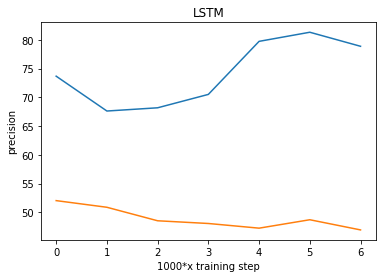

precision of the model on thevalidationdata: 48.94698715209961%
tensor([0.7130, 0.5966, 0.6946, 0.9924, 0.9642, 0.9997, 0.7734, 0.8849, 0.7228,
        0.9052, 0.7994, 0.9271, 0.9974, 0.5610, 0.7837, 0.6698, 0.6394, 0.6280,
        0.6890, 0.6096, 0.6392, 0.9112, 0.6016, 0.6181, 0.5984, 0.6008, 0.5917,
        0.7182, 0.6802, 0.7291, 0.6202, 0.5944, 0.5980, 0.6427, 0.5365, 0.5666,
        0.7368, 0.7231, 0.6514, 1.0000, 0.8602, 0.9935, 0.9642, 0.5657, 0.6170,
        1.0000, 1.0000, 0.9999, 1.0000, 0.9014, 0.5078, 0.7722, 0.7465, 0.9519,
        0.9833, 0.9993, 0.5866, 0.6591, 0.6743, 0.5816, 0.7076, 0.7270, 0.6793,
        0.5886, 0.6118, 0.5989, 0.9755, 0.6798, 0.8694, 0.6290, 0.5416, 0.6415,
        0.7293, 0.6720, 0.5553, 0.5963, 0.5962, 0.6006, 0.9856, 0.6233, 0.6184,
        0.6350, 0.5316, 0.5226, 0.8793, 0.6227, 0.6606, 0.9989, 0.6919, 0.9177,
        0.9851, 0.6120, 0.9183, 0.9131, 0.9868, 0.5578, 0.9987, 0.6051, 0.5393,
        0.5398], device='cuda:1')
current i is 19
Filter

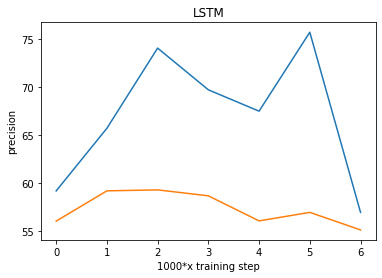

precision of the model on thevalidationdata: 54.90375900268555%
tensor([0.9785, 0.5094, 0.5486, 0.9992, 1.0000, 0.7845, 0.6091, 0.6870, 0.5405,
        0.5402, 0.5096, 0.6033, 0.5303, 0.5117, 0.5119, 1.0000, 0.9998, 0.8310,
        0.5253, 0.5096, 0.6524, 0.5073, 0.5096, 0.6400, 0.9336, 0.7317, 0.6527,
        0.5348, 0.5344, 0.5766, 0.5932, 0.5378, 0.5947, 0.5077, 0.5096, 0.7075,
        0.5474, 0.9899, 1.0000, 0.9839, 0.5310, 0.5096, 0.5096, 0.5097, 0.5246,
        0.5262, 0.6549, 0.9206, 0.5054, 0.6113, 0.5554, 0.5843, 0.5090, 0.6106,
        0.5003, 0.5281, 0.5401, 0.6289, 0.5623, 0.6163, 0.6130, 0.5235, 0.5355,
        0.5373, 0.5687, 0.9046, 0.7311, 0.6193, 0.5180, 0.6302, 0.5414, 0.5784,
        0.5275, 0.7142, 0.7534, 0.7764, 0.5096, 0.5096, 0.5095, 0.5695, 0.5389,
        0.7888, 0.5142, 0.5097, 0.5096, 0.5096, 0.5096, 0.5096, 0.5090, 0.5090,
        0.5102, 0.5096, 0.5096, 0.7877, 0.7364, 0.8409, 0.9366, 0.6764, 0.6772,
        0.6990], device='cuda:1')
current i is 20
Filter

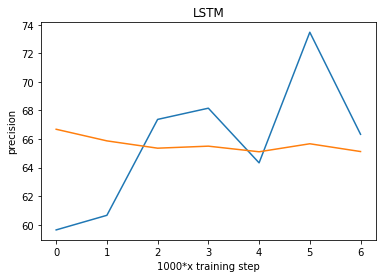

precision of the model on thevalidationdata: 65.04009246826172%
tensor([1.0000, 1.0000, 0.9995, 0.6393, 0.8085, 0.9291, 0.8763, 0.7388, 0.6644,
        0.7863, 0.9897, 0.9965, 0.5607, 0.6497, 0.9602, 0.6521, 0.6423, 0.5401,
        0.5770, 0.6990, 0.8311, 0.6659, 0.5508, 1.0000, 0.9871, 1.0000, 0.9996,
        0.7375, 0.9259, 0.9884, 0.6340, 0.5101, 0.5261, 0.6962, 0.5604, 0.6841,
        0.6119, 0.9999, 0.9094, 0.8874, 0.6281, 1.0000, 0.9995, 1.0000, 0.8359,
        0.8705, 0.8119, 0.5662, 0.6326, 0.6326, 0.8287, 0.5093, 0.5108, 0.5787,
        0.8724, 0.6746, 0.7942, 0.8787, 0.9453, 0.8732, 0.5428, 0.9957, 0.5267,
        0.8688, 0.6984, 0.5781, 0.5945, 0.5832, 0.7499, 0.6430, 0.5423, 0.5225,
        0.5443, 0.6707, 0.6053, 0.6496, 0.9789, 0.7077, 0.9993, 0.8265, 0.9999,
        0.9745, 1.0000, 0.9228, 0.7422, 0.7157, 0.5634, 0.5592, 0.8218, 0.5098,
        0.5061, 0.5383, 0.6992, 1.0000, 1.0000, 0.5474, 0.6268, 0.5462, 0.9611,
        0.9945], device='cuda:1')
current i is 21
Filter

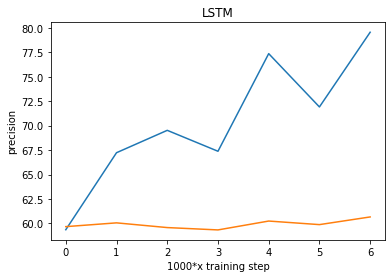

precision of the model on thevalidationdata: 60.21660614013672%
tensor([1.0000, 0.9319, 0.6123, 0.6314, 0.5058, 0.5158, 0.6066, 0.6950, 0.6488,
        0.9430, 0.9928, 0.9820, 0.5452, 1.0000, 1.0000, 0.9999, 0.5752, 0.6599,
        0.6510, 0.5539, 0.7168, 0.6433, 0.8989, 0.6273, 0.6039, 0.5252, 0.7011,
        0.6708, 0.5886, 0.7151, 0.5924, 0.8898, 0.9128, 0.9943, 0.9667, 0.9866,
        0.8801, 0.6497, 0.5317, 0.9999, 0.6688, 0.5178, 0.7689, 0.5740, 0.6036,
        0.9057, 0.5805, 0.6451, 0.6605, 0.6866, 0.8345, 0.6241, 0.7969, 0.8109,
        0.6551, 0.8193, 0.9999, 0.8033, 0.5647, 0.7497, 0.5338, 0.5790, 0.8455,
        0.6683, 0.9512, 1.0000, 0.5387, 0.9824, 1.0000, 1.0000, 1.0000, 0.9997,
        0.5358, 0.6346, 0.5613, 0.7323, 0.6219, 0.6457, 0.6131, 0.7625, 0.7617,
        0.5611, 0.9980, 0.9993, 0.6676, 0.8811, 0.9895, 0.6053, 0.9189, 0.9998,
        0.9333, 0.9999, 0.9040, 0.6214, 0.9993, 0.9960, 0.5080, 0.6831, 0.9893,
        1.0000], device='cuda:1')
current i is 22
Filter

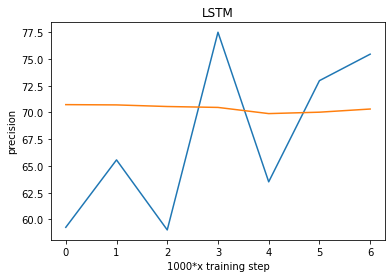

precision of the model on thevalidationdata: 70.64393615722656%
tensor([1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 0.9563, 1.0000, 1.0000, 0.9999,
        0.7017, 1.0000, 0.9999, 1.0000, 1.0000, 0.9993, 0.9992, 1.0000, 1.0000,
        0.9996, 0.9941, 1.0000, 1.0000, 0.5036, 1.0000, 1.0000, 1.0000, 0.9688,
        1.0000, 0.9700, 0.9995, 0.7220, 1.0000, 0.6972, 0.9968, 0.8647, 1.0000,
        1.0000, 0.9596, 0.9992, 1.0000, 0.9998, 0.9996, 1.0000, 0.6298, 0.9594,
        0.6787, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.8498, 1.0000, 1.0000, 0.9999, 0.9998, 0.8585, 0.9985, 1.0000,
        1.0000, 0.6944, 0.9460, 0.9886, 1.0000, 0.9979, 0.9539, 1.0000, 0.8128,
        0.9110, 0.8774, 0.6784, 0.6100, 0.9975, 1.0000, 0.9994, 0.9999, 0.9984,
        1.0000, 0.9999, 1.0000, 1.0000, 0.5528, 0.9998, 1.0000, 0.9767, 1.0000,
        1.0000, 0.9998, 0.9860, 0.9693, 1.0000, 1.0000, 0.7603, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 23
Filter

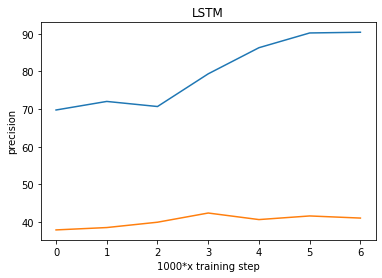

precision of the model on thevalidationdata: 40.821712493896484%
tensor([0.9975, 0.9971, 0.9994, 0.6712, 0.9385, 0.7945, 0.9972, 1.0000, 0.9995,
        1.0000, 1.0000, 0.9737, 0.5879, 0.7688, 0.8186, 0.9990, 0.9682, 1.0000,
        0.9936, 0.6755, 0.8859, 1.0000, 0.9980, 0.9235, 1.0000, 1.0000, 0.9996,
        0.9999, 0.9948, 0.7671, 0.6402, 0.9124, 0.7973, 0.9253, 1.0000, 0.9672,
        0.9960, 0.9907, 0.6026, 1.0000, 1.0000, 0.9932, 0.8462, 0.9340, 0.9876,
        0.9998, 0.9999, 0.9975, 0.6777, 0.6157, 0.7138, 0.5399, 0.9931, 0.7180,
        0.9105, 0.9999, 0.9917, 0.7798, 0.9906, 0.9949, 0.9982, 1.0000, 0.7447,
        0.9922, 0.9985, 0.9264, 1.0000, 0.9995, 0.6803, 0.9997, 0.9998, 1.0000,
        0.9841, 0.8888, 0.9996, 0.9989, 1.0000, 0.8329, 0.9999, 0.9991, 0.9910,
        0.9401, 0.7683, 1.0000, 0.9993, 0.8067, 0.9765, 0.6523, 0.9990, 0.5316,
        0.9987, 1.0000, 1.0000, 0.6166, 0.8190, 0.6139, 0.9996, 1.0000, 1.0000,
        0.5255], device='cuda:1')
current i is 24
Filte

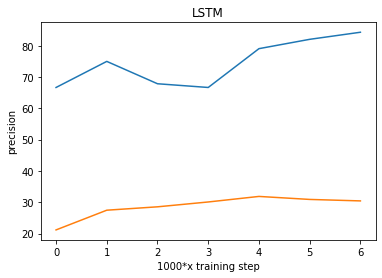

precision of the model on thevalidationdata: 30.372493743896484%
tensor([1.0000, 1.0000, 0.9694, 0.9994, 1.0000, 0.6780, 0.6887, 1.0000, 0.9999,
        0.6467, 0.5236, 0.6971, 0.6661, 0.6936, 0.9473, 0.5982, 0.9997, 1.0000,
        0.9417, 0.5983, 0.7305, 0.6308, 0.5846, 0.5320, 0.7627, 0.7690, 0.9475,
        0.9531, 0.5826, 0.6362, 0.7120, 0.9945, 0.9969, 0.7409, 1.0000, 1.0000,
        1.0000, 0.5519, 0.8390, 0.7561, 0.8227, 0.8571, 0.5966, 0.7391, 0.5141,
        0.7335, 1.0000, 1.0000, 0.8637, 0.6372, 0.5219, 0.6103, 1.0000, 0.9998,
        0.6605, 0.6624, 1.0000, 1.0000, 1.0000, 1.0000, 0.6191, 0.9986, 0.8231,
        0.7081, 0.7025, 0.6554, 0.5382, 0.6673, 0.6404, 0.6451, 0.8498, 0.9696,
        0.5612, 0.7679, 0.8672, 0.9457, 0.9931, 1.0000, 1.0000, 0.9409, 0.5406,
        0.7173, 0.7860, 0.8668, 0.8625, 0.6421, 0.7680, 0.6452, 0.6616, 0.5902,
        0.6679, 0.6039, 0.5737, 0.8238, 0.5701, 0.5321, 0.7825, 0.7063, 0.5553,
        0.6700], device='cuda:1')
current i is 25
Filte

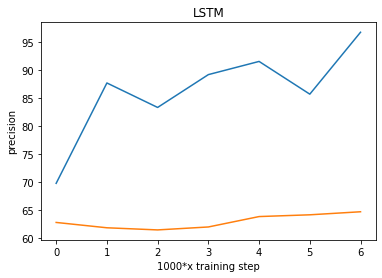

precision of the model on thevalidationdata: 65.36367797851562%
tensor([1.0000, 0.7928, 1.0000, 0.8706, 0.9924, 0.9796, 0.7434, 0.5732, 0.9523,
        0.5487, 1.0000, 0.9933, 0.7906, 0.9767, 0.5854, 1.0000, 0.9996, 0.7583,
        0.5433, 0.9997, 1.0000, 1.0000, 0.9977, 0.6662, 1.0000, 0.5699, 0.9976,
        0.9998, 0.5196, 0.6131, 0.5430, 0.8960, 0.5541, 0.9985, 0.9998, 0.9942,
        0.9997, 0.8545, 0.9999, 0.5246, 0.6143, 0.5895, 0.5879, 0.9990, 0.9977,
        0.9029, 0.5016, 0.6325, 0.5931, 0.9781, 0.9997, 1.0000, 0.9998, 0.9807,
        1.0000, 0.5733, 0.5987, 0.6041, 1.0000, 1.0000, 0.9999, 0.8899, 0.9871,
        0.8163, 0.9295, 0.9658, 0.9991, 0.5214, 0.5179, 0.5683, 0.6081, 0.8763,
        0.6788, 0.6775, 0.5468, 0.6071, 1.0000, 1.0000, 1.0000, 0.9992, 0.6180,
        0.7608, 0.9836, 0.9447, 0.6696, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9998, 0.5162, 0.6638, 0.7813, 1.0000, 1.0000, 0.9900, 0.9990, 0.8357,
        0.9993], device='cuda:1')
current i is 26
Filter

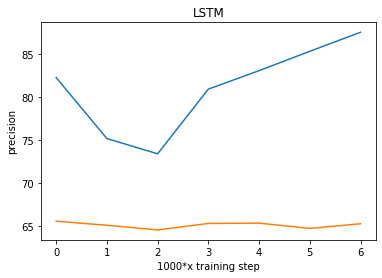

precision of the model on thevalidationdata: 64.72931671142578%
tensor([0.9993, 1.0000, 0.9826, 1.0000, 0.8073, 1.0000, 1.0000, 0.9999, 0.9987,
        0.6701, 1.0000, 0.6016, 1.0000, 1.0000, 0.5819, 0.6677, 0.5632, 0.9945,
        1.0000, 0.9915, 1.0000, 0.8936, 1.0000, 1.0000, 0.7561, 0.6547, 0.9380,
        0.9991, 0.9989, 0.9750, 0.9634, 0.6873, 0.6815, 0.9664, 0.9995, 0.9865,
        0.9983, 0.6049, 1.0000, 0.8551, 0.9614, 0.6648, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9998, 1.0000, 0.9848, 0.6864, 0.5271, 0.9997, 1.0000, 0.9995,
        0.9971, 0.9640, 0.9143, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000, 0.9942,
        0.9980, 1.0000, 0.9999, 0.9993, 1.0000, 1.0000, 1.0000, 1.0000, 0.9925,
        1.0000, 0.5448, 0.9977, 0.9956, 0.9990, 1.0000, 0.6922, 0.7971, 0.8148,
        0.9800, 1.0000, 1.0000, 1.0000, 0.9843, 0.9985, 0.9004, 0.9252, 0.9429,
        1.0000, 1.0000, 1.0000, 0.9554, 0.9560, 0.7464, 0.9976, 1.0000, 0.9829,
        0.5564], device='cuda:1')
current i is 27
Filter

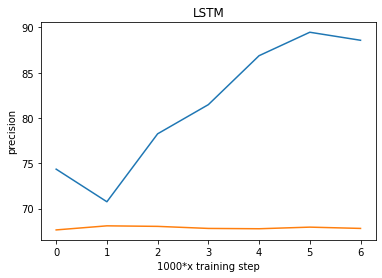

precision of the model on thevalidationdata: 68.37251281738281%
tensor([1.0000, 1.0000, 0.9998, 1.0000, 0.9994, 0.9885, 0.6724, 0.5705, 0.5099,
        0.6184, 0.5906, 0.6165, 0.6165, 0.7474, 0.7152, 0.6165, 0.5787, 0.5610,
        0.5379, 0.6164, 0.6162, 0.6165, 0.6088, 0.7253, 0.6163, 0.6165, 0.6164,
        0.6165, 0.9929, 0.8873, 0.9987, 0.9990, 0.8576, 0.5399, 1.0000, 0.9365,
        0.5466, 0.6160, 0.6154, 0.6139, 0.7358, 0.7158, 0.6501, 0.5962, 0.5600,
        0.5209, 0.5848, 0.9967, 0.9957, 0.8360, 0.9990, 0.8318, 0.9933, 0.8799,
        0.7497, 0.6689, 0.8333, 0.9955, 0.6173, 0.6042, 0.5733, 0.5604, 0.7379,
        0.6877, 0.6164, 0.6159, 0.6165, 0.6165, 0.6164, 0.6164, 0.9990, 0.9473,
        0.9955, 0.7407, 0.6526, 0.5989, 0.5594, 0.5993, 0.5965, 0.6164, 0.6163,
        0.6161, 0.7325, 0.6583, 0.5711, 0.6828, 0.5615, 0.9712, 0.5334, 0.5099,
        0.6082, 1.0000, 0.9839, 1.0000, 0.6287, 0.6277, 0.6137, 0.6161, 0.9779,
        1.0000], device='cuda:1')
current i is 28
Filter

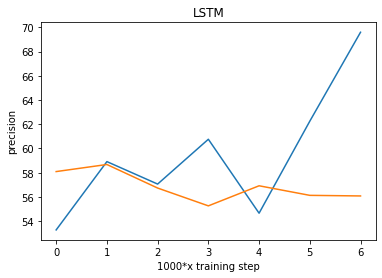

precision of the model on thevalidationdata: 56.18212127685547%
tensor([0.5234, 0.5234, 0.6870, 0.5932, 0.5470, 0.6703, 0.6062, 0.6814, 0.5240,
        0.5304, 0.5122, 0.5558, 0.5040, 0.5295, 0.5017, 0.6442, 0.5127, 0.5646,
        0.5326, 0.5237, 0.9400, 0.9999, 0.5618, 0.5629, 0.9995, 0.9977, 0.5247,
        0.5518, 0.5120, 0.5170, 0.9862, 0.6305, 0.5452, 0.5685, 0.5003, 0.5453,
        0.7336, 0.9943, 0.7127, 0.7654, 0.5208, 0.5726, 0.5180, 0.5338, 0.7140,
        0.5613, 0.5446, 0.5337, 0.5241, 0.5224, 0.5326, 0.5633, 0.5170, 0.5343,
        0.5378, 0.5143, 0.5190, 0.5508, 0.5019, 0.6068, 0.6438, 0.9926, 0.5433,
        0.5051, 0.9999, 1.0000, 0.9968, 0.9975, 0.7000, 0.6740, 0.5711, 0.6120,
        0.9999, 0.9993, 0.7264, 0.7147, 0.5146, 0.5912, 0.5241, 0.5500, 0.5776,
        0.6321, 0.7880, 0.9971, 0.5234, 0.5626, 0.5159, 0.5036, 0.5126, 0.5210,
        0.5249, 0.8120, 0.7710, 0.9967, 0.9904, 0.5111, 0.6766, 0.5627, 0.5438,
        0.5199], device='cuda:1')
current i is 29
Filter

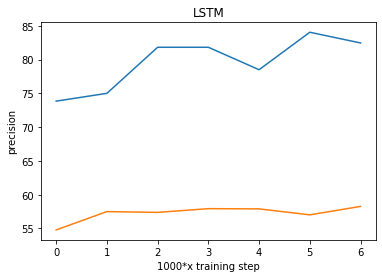

precision of the model on thevalidationdata: 58.21181869506836%
tensor([0.9997, 1.0000, 1.0000, 1.0000, 0.9995, 0.9989, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.6108, 0.9420, 1.0000, 0.9993, 1.0000, 0.9953, 0.9956,
        0.9996, 0.9995, 1.0000, 1.0000, 0.9944, 1.0000, 0.9997, 1.0000, 0.9505,
        0.9802, 0.9053, 0.5336, 1.0000, 1.0000, 0.9996, 0.7854, 0.8663, 1.0000,
        0.7490, 1.0000, 1.0000, 0.9686, 1.0000, 0.9897, 0.9702, 1.0000, 0.7974,
        0.9202, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.7313, 0.9622, 0.9999, 1.0000, 1.0000, 1.0000, 0.7583, 0.5335, 1.0000,
        0.9999, 0.8011, 1.0000, 1.0000, 0.9993, 0.9991, 0.9957, 0.9996, 1.0000,
        0.9998, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 0.7975, 0.9933, 1.0000,
        0.9974, 1.0000, 0.9996, 1.0000, 1.0000, 0.6882, 1.0000, 0.9999, 0.6696,
        1.0000, 1.0000, 0.9998, 0.8758, 0.9889, 1.0000, 0.6128, 0.6633, 0.8247,
        0.5460], device='cuda:1')
current i is 30
Filter

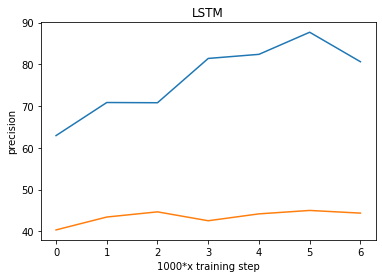

precision of the model on thevalidationdata: 47.86271286010742%
tensor([0.9206, 0.9374, 1.0000, 0.9974, 1.0000, 0.9992, 0.6152, 0.8128, 0.5863,
        0.5962, 0.6948, 0.5495, 0.5470, 0.9989, 0.5842, 0.7762, 0.9975, 0.5129,
        0.9995, 0.9928, 0.9999, 0.7049, 0.7785, 0.8995, 0.9999, 1.0000, 0.7890,
        0.5469, 0.7654, 0.5060, 0.7451, 0.9478, 0.9571, 0.9018, 0.9806, 0.8802,
        0.7193, 0.9991, 0.8644, 0.7771, 0.9947, 0.9821, 0.6704, 0.6884, 0.5318,
        0.9257, 0.6942, 0.9511, 0.5959, 0.9953, 0.5860, 0.6975, 0.8600, 0.9426,
        0.9988, 0.9174, 0.9993, 0.7953, 0.6131, 0.5767, 0.6855, 0.8477, 0.9262,
        0.8735, 0.9057, 0.9882, 0.6358, 0.5197, 0.9987, 0.9384, 0.9897, 0.8872,
        0.5662, 0.5662, 0.5662, 0.9936, 0.9930, 0.9289, 0.9992, 0.9954, 0.8325,
        0.8660, 0.9586, 0.9704, 0.5662, 1.0000, 1.0000, 0.5581, 0.6894, 0.6153,
        0.9997, 0.8680, 0.8999, 0.6794, 0.5730, 0.5469, 0.9825, 0.8352, 0.9429,
        0.9945], device='cuda:1')
current i is 31
Filter

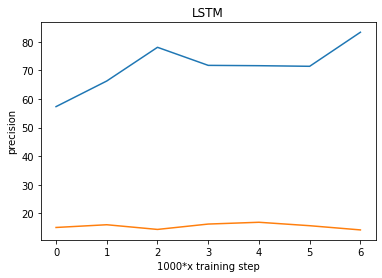

precision of the model on thevalidationdata: 16.04838752746582%
tensor([0.9883, 1.0000, 0.9611, 0.9999, 0.6873, 0.9779, 0.9946, 0.8246, 0.9996,
        0.9774, 0.9975, 0.9659, 0.8458, 0.7158, 1.0000, 1.0000, 1.0000, 0.9999,
        0.9999, 0.9931, 1.0000, 0.9330, 0.9782, 0.9489, 0.9095, 0.5036, 0.9999,
        0.9993, 0.8353, 0.9997, 0.9643, 0.9951, 0.9956, 1.0000, 0.9980, 0.9996,
        0.9997, 0.9815, 0.7920, 1.0000, 1.0000, 0.8510, 0.9999, 1.0000, 0.9945,
        0.9957, 0.9919, 0.9996, 1.0000, 0.9986, 1.0000, 0.9999, 0.9701, 0.5435,
        0.8811, 0.8650, 0.9918, 1.0000, 0.9609, 0.9998, 1.0000, 0.9925, 0.9850,
        0.7945, 0.9999, 0.5955, 0.9785, 0.8696, 0.9974, 0.8278, 0.7943, 0.8944,
        0.7316, 0.9862, 0.9990, 0.9801, 0.9730, 0.7980, 0.8298, 0.8393, 0.9990,
        0.8927, 0.9877, 0.9098, 1.0000, 0.9994, 0.9968, 0.9810, 0.9913, 0.9982,
        1.0000, 1.0000, 0.9999, 1.0000, 0.6036, 0.5625, 0.9880, 1.0000, 0.9929,
        0.9208], device='cuda:1')
current i is 32
Filter

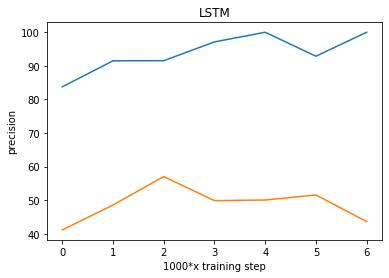

precision of the model on thevalidationdata: 61.6895866394043%
tensor([0.9999, 0.9583, 0.9998, 0.9984, 0.9999, 1.0000, 0.9999, 1.0000, 1.0000,
        0.7540, 1.0000, 1.0000, 0.9836, 0.9977, 0.9939, 0.9297, 0.7216, 0.5274,
        0.5274, 0.5274, 0.9990, 0.9997, 0.6084, 0.9935, 0.7186, 0.6948, 1.0000,
        0.9445, 0.6618, 0.5274, 0.6493, 0.8717, 1.0000, 0.9995, 0.9999, 1.0000,
        1.0000, 1.0000, 0.5275, 0.5274, 0.5274, 0.9968, 0.9291, 0.8240, 0.5759,
        0.5152, 0.5459, 0.5084, 0.5340, 0.9960, 0.7840, 0.7376, 0.9645, 1.0000,
        0.9999, 1.0000, 0.8205, 0.6072, 0.9906, 0.9995, 0.5420, 0.9738, 0.9998,
        0.9999, 0.9279, 0.9991, 0.6062, 0.9996, 0.9238, 0.6187, 0.9988, 0.5453,
        0.5321, 0.5238, 0.9934, 0.9036, 0.9562, 1.0000, 0.9996, 0.9906, 0.5307,
        0.8721, 0.7108, 0.7855, 1.0000, 1.0000, 0.6188, 0.5512, 0.6362, 0.9980,
        0.9039, 0.5569, 1.0000, 0.9975, 0.9859, 0.5220, 0.5518, 0.7557, 0.9934,
        0.9993], device='cuda:1')
current i is 33
Filter 

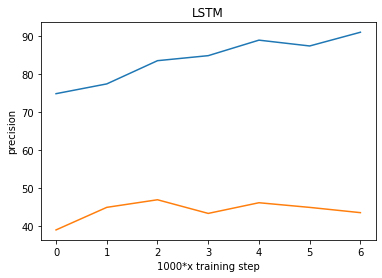

precision of the model on thevalidationdata: 43.125%
tensor([1.0000, 1.0000, 0.8549, 0.9104, 0.5371, 0.7708, 1.0000, 0.9747, 0.5633,
        0.7275, 0.8870, 1.0000, 0.9980, 1.0000, 1.0000, 1.0000, 1.0000, 0.9988,
        0.9997, 1.0000, 1.0000, 0.9998, 1.0000, 0.5798, 1.0000, 1.0000, 1.0000,
        0.9805, 1.0000, 0.9855, 1.0000, 0.9986, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9997, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 0.9920, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9500, 0.9999, 0.9998, 0.9628, 1.0000, 0.9958,
        0.9527, 0.9998, 0.8188, 0.9824, 1.0000, 0.9366, 0.9598, 1.0000, 0.9997,
        0.9961, 1.0000, 0.5217, 0.9999, 1.0000, 0.9998, 1.0000, 0.9998, 0.9984,
        1.0000, 1.0000, 0.9994, 1.0000, 0.9986, 0.7746, 0.9942, 0.9973, 1.0000,
        1.0000, 0.9868, 1.0000, 0.7954, 0.9077, 0.9997, 0.7602, 0.9838, 1.0000,
        0.9967, 1.0000, 0.9907, 1.0000, 1.0000, 0.9974, 0.9953, 0.9989, 0.8812,
        1.0000], device='cuda:1')
current i is 34
Filter large gap.

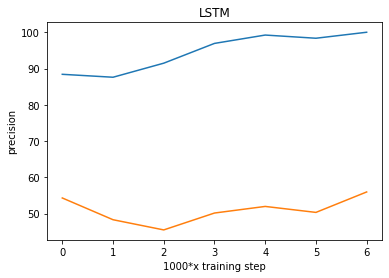

precision of the model on thevalidationdata: 51.720115661621094%
tensor([0.9250, 0.9997, 1.0000, 0.9989, 0.9979, 0.9953, 0.9997, 0.5788, 0.8006,
        0.9971, 0.5786, 0.8939, 0.8484, 0.5746, 0.9995, 0.7532, 0.9999, 1.0000,
        0.9990, 0.9083, 0.7439, 0.9978, 0.8623, 0.6727, 0.9791, 0.9537, 0.7785,
        0.9446, 0.9123, 0.9416, 0.9983, 0.5631, 0.9528, 0.9998, 1.0000, 0.8309,
        0.5943, 0.7423, 0.7042, 0.9629, 0.9241, 0.5113, 1.0000, 1.0000, 0.9998,
        0.8084, 0.7099, 0.9959, 0.9799, 1.0000, 0.8698, 0.9981, 0.9999, 0.9996,
        0.9981, 1.0000, 0.9999, 0.9986, 0.6811, 0.7581, 0.9897, 0.9941, 0.9584,
        0.9998, 0.9426, 0.9742, 0.9963, 0.9424, 0.6328, 0.9988, 0.9017, 0.9822,
        1.0000, 0.9992, 0.9979, 0.9999, 0.9979, 0.9795, 0.9904, 0.9999, 0.9914,
        0.9479, 0.8552, 1.0000, 0.9995, 0.9965, 0.9933, 0.7185, 0.9999, 0.9431,
        0.8044, 0.6807, 0.5426, 0.9890, 0.9987, 0.9999, 1.0000, 1.0000, 0.9018,
        0.5778], device='cuda:1')
current i is 35
Filte

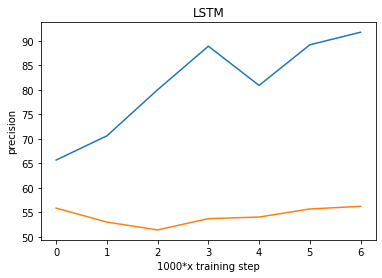

precision of the model on thevalidationdata: 55.75846862792969%
tensor([0.5113, 0.6667, 0.8678, 0.7662, 0.5111, 0.7734, 0.5107, 0.5380, 0.8380,
        0.5223, 0.6801, 0.7164, 0.5698, 0.5407, 0.6681, 0.6171, 0.6844, 0.8080,
        0.9998, 0.9997, 0.9960, 0.6223, 0.5858, 0.8554, 0.5159, 0.7479, 0.7828,
        0.6165, 0.6499, 0.8349, 0.5493, 0.6244, 0.7570, 1.0000, 0.9371, 0.9958,
        0.6254, 0.6756, 0.5979, 0.6786, 0.7299, 0.5234, 0.5238, 0.7254, 0.7838,
        0.7991, 0.5236, 0.6993, 0.7413, 0.8528, 0.6595, 0.6208, 0.8716, 0.5166,
        0.5470, 0.9182, 0.5505, 0.7364, 0.7756, 0.5525, 0.5223, 0.8183, 0.5761,
        0.5531, 0.6359, 0.9995, 1.0000, 0.9364, 0.6730, 0.6789, 0.8238, 0.5587,
        0.7387, 0.7527, 0.7645, 0.8714, 0.6153, 0.7003, 0.7364, 0.7484, 0.9985,
        0.9583, 0.9218, 0.6422, 0.7051, 0.8234, 0.5731, 0.6956, 0.7585, 0.5444,
        0.5333, 0.5318, 0.7021, 0.5612, 0.5758, 0.9972, 0.6133, 0.9998, 0.5107,
        0.6175], device='cuda:1')
current i is 36
Filter

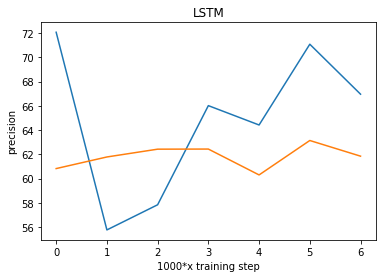

precision of the model on thevalidationdata: 61.87398910522461%
tensor([0.6189, 0.5847, 0.6106, 0.6139, 0.6416, 0.6854, 0.7546, 0.9327, 0.5915,
        0.8414, 0.6817, 0.6149, 0.6315, 0.7700, 0.5821, 0.6730, 0.6999, 0.7394,
        0.8424, 0.7108, 0.7743, 0.8027, 0.7332, 0.7151, 0.8810, 0.8700, 0.5237,
        0.7611, 0.9046, 0.6055, 0.8602, 0.8974, 0.9504, 1.0000, 0.9997, 1.0000,
        0.9397, 0.7744, 0.9897, 0.9377, 0.5274, 0.8553, 0.7499, 0.6991, 0.7247,
        1.0000, 0.7158, 1.0000, 0.8250, 0.9030, 0.7803, 0.7045, 0.6972, 0.6796,
        0.5332, 0.9998, 0.9989, 0.8060, 0.8450, 0.7796, 0.6009, 0.6668, 0.5790,
        0.7683, 0.7769, 0.5549, 0.7123, 0.7356, 0.6490, 0.8070, 0.7484, 0.7186,
        0.5496, 0.9998, 0.7564, 0.8394, 0.9502, 0.8085, 0.6602, 0.6646, 0.5815,
        0.8303, 0.8682, 0.7477, 0.6297, 0.5635, 0.5978, 0.8156, 0.8961, 0.7360,
        0.6609, 0.6833, 0.6223, 0.8449, 0.8000, 0.9591, 0.8897, 0.6456, 0.7265,
        0.8347], device='cuda:1')
current i is 37
Filter

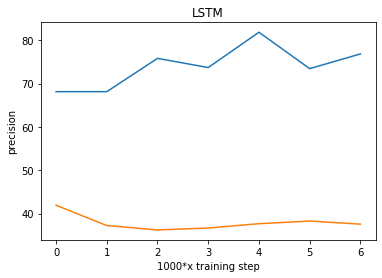

precision of the model on thevalidationdata: 37.77705383300781%
tensor([0.8071, 0.9997, 1.0000, 0.9999, 0.9717, 0.8423, 0.5057, 0.6440, 0.6559,
        0.9997, 1.0000, 1.0000, 0.5850, 1.0000, 0.6510, 0.6557, 0.9835, 1.0000,
        0.9906, 0.9999, 1.0000, 0.7640, 0.7149, 0.6129, 1.0000, 0.9985, 0.7688,
        0.7781, 0.5435, 0.5999, 0.8588, 0.9886, 0.9966, 0.9757, 1.0000, 1.0000,
        0.6500, 0.6426, 0.5794, 0.5523, 0.6942, 0.9410, 1.0000, 0.9611, 0.9999,
        0.7308, 0.9985, 1.0000, 0.9821, 0.9933, 0.6070, 1.0000, 0.5738, 0.9999,
        0.5329, 0.5386, 0.6114, 0.6589, 0.7062, 0.7286, 0.7798, 0.7265, 0.9999,
        0.9971, 0.9937, 1.0000, 1.0000, 0.9514, 1.0000, 0.9924, 0.9815, 0.9967,
        0.9980, 0.9965, 0.9486, 0.5437, 0.6264, 0.6871, 0.9979, 0.9849, 0.7439,
        1.0000, 1.0000, 0.9969, 0.9820, 0.9984, 0.7772, 0.9997, 0.9994, 0.7813,
        0.5617, 0.8654, 0.5780, 0.9998, 0.7636, 0.9569, 0.9984, 0.9946, 0.9976,
        0.9982], device='cuda:1')
current i is 38
Filter

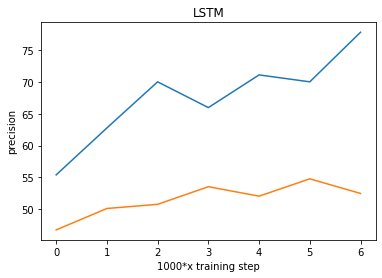

precision of the model on thevalidationdata: 54.02900695800781%
tensor([1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 0.9119, 0.9971, 0.5538,
        1.0000, 1.0000, 1.0000, 0.9982, 1.0000, 1.0000, 1.0000, 0.9929, 1.0000,
        0.9942, 1.0000, 1.0000, 0.9974, 0.9565, 1.0000, 1.0000, 0.9998, 0.9914,
        0.9578, 1.0000, 1.0000, 0.9996, 0.9997, 0.9859, 0.9979, 0.9941, 0.9998,
        0.9991, 0.9973, 0.9987, 0.9978, 0.9857, 0.9896, 0.9553, 1.0000, 0.9993,
        1.0000, 0.9978, 0.9987, 0.9812, 1.0000, 1.0000, 1.0000, 0.9970, 0.9983,
        0.9991, 0.9169, 1.0000, 0.9961, 1.0000, 1.0000, 0.9974, 0.9959, 0.9998,
        1.0000, 0.9998, 0.9993, 1.0000, 0.9998, 0.9848, 0.9732, 1.0000, 1.0000,
        1.0000, 0.9986, 0.9653, 0.6574, 1.0000, 0.9021, 1.0000, 0.7932, 1.0000,
        1.0000, 1.0000, 0.9502, 0.6448, 1.0000, 1.0000, 0.9995, 1.0000, 0.9995,
        0.9947, 1.0000, 0.9999, 0.5185, 1.0000, 0.9946, 0.9998, 0.5495, 0.9990,
        0.8613], device='cuda:1')
current i is 39
Filter

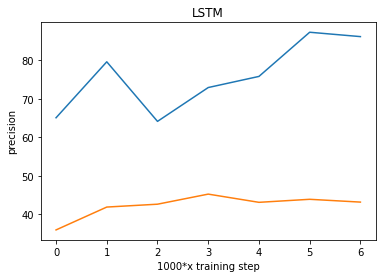

precision of the model on thevalidationdata: 43.194393157958984%
tensor([1.0000, 1.0000, 0.8303, 1.0000, 0.9940, 0.9996, 0.9890, 0.9624, 1.0000,
        0.9990, 0.6062, 0.5419, 0.7832, 0.6155, 0.5223, 0.9998, 0.9751, 0.9912,
        1.0000, 1.0000, 0.9940, 0.9893, 0.9999, 1.0000, 0.8267, 0.8433, 1.0000,
        1.0000, 0.7557, 1.0000, 0.9014, 0.7744, 0.6107, 0.9894, 0.9990, 1.0000,
        0.9981, 1.0000, 0.9991, 0.9875, 1.0000, 1.0000, 0.7846, 0.7413, 0.9188,
        0.9997, 0.8211, 0.6335, 0.6570, 0.6496, 0.8206, 0.9984, 1.0000, 1.0000,
        0.9937, 0.8759, 0.9995, 0.7038, 0.9633, 0.9038, 0.9525, 0.9090, 0.9871,
        0.9899, 0.8363, 0.9888, 0.6620, 0.5051, 0.6522, 0.8816, 0.8878, 0.9999,
        0.8256, 0.5363, 0.6447, 0.9844, 0.9575, 0.5602, 1.0000, 1.0000, 1.0000,
        0.8380, 0.6702, 0.7131, 0.9819, 0.5739, 0.6834, 1.0000, 1.0000, 1.0000,
        0.9724, 1.0000, 0.9959, 0.9980, 0.9996, 1.0000, 0.8236, 0.9730, 0.9898,
        0.9632], device='cuda:1')
current i is 41
Filte

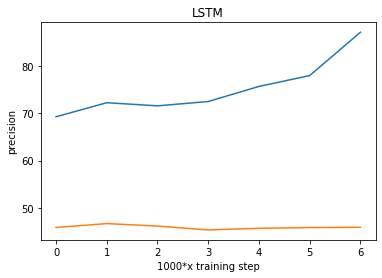

precision of the model on thevalidationdata: 46.79328536987305%
tensor([0.5378, 0.7184, 0.6562, 0.7851, 0.8585, 0.9580, 0.5047, 0.5769, 0.5347,
        0.7329, 0.9377, 0.9981, 0.8919, 0.9923, 0.5163, 0.8150, 0.5064, 0.5657,
        0.5779, 0.9029, 0.5402, 0.5348, 0.5136, 0.9864, 0.9906, 0.9956, 0.6108,
        0.7960, 0.5181, 0.9865, 0.5258, 0.9928, 0.6057, 0.6608, 0.6077, 0.7785,
        0.7001, 0.8397, 0.6297, 0.6126, 0.5396, 0.8279, 0.5166, 0.6745, 0.6680,
        0.6538, 0.9151, 0.6971, 0.6976, 0.9947, 0.5875, 0.5463, 0.6616, 0.8905,
        0.5891, 0.5207, 0.6986, 0.6515, 0.9841, 0.9989, 0.9273, 0.5192, 0.5572,
        0.6017, 0.6627, 0.7104, 0.6204, 0.5464, 0.6228, 0.5635, 0.5443, 0.6707,
        0.5588, 0.5936, 0.5249, 0.5533, 0.5449, 0.5825, 0.6495, 0.5257, 0.9618,
        0.6991, 0.5287, 0.8465, 1.0000, 0.7439, 0.5088, 0.6366, 0.5031, 0.5517,
        0.9939, 0.5244, 0.5352, 0.5127, 0.5466, 0.6807, 0.5900, 0.5171, 0.5937,
        0.9671], device='cuda:1')
current i is 42
Filter

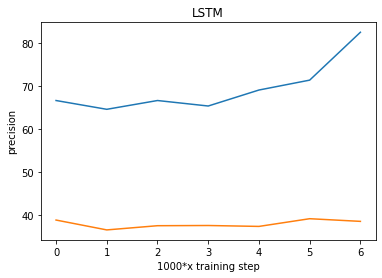

precision of the model on thevalidationdata: 37.65659713745117%
tensor([0.9975, 1.0000, 1.0000, 1.0000, 0.5360, 1.0000, 0.9529, 0.5935, 1.0000,
        1.0000, 0.5881, 0.5731, 0.8094, 1.0000, 0.5354, 0.9445, 0.5612, 0.6494,
        1.0000, 0.9990, 1.0000, 1.0000, 0.9026, 0.6162, 1.0000, 0.9860, 0.8329,
        0.6065, 0.9999, 1.0000, 0.9999, 0.9963, 1.0000, 0.9178, 0.9998, 0.9927,
        0.5382, 0.9857, 0.9654, 0.8559, 0.9837, 0.9180, 1.0000, 1.0000, 0.9999,
        0.9998, 0.9976, 0.9985, 0.9903, 0.9978, 0.5012, 0.6156, 0.9988, 1.0000,
        0.5593, 0.6416, 1.0000, 1.0000, 0.6318, 1.0000, 0.5975, 0.6613, 0.7777,
        0.9994, 0.6273, 0.8616, 1.0000, 0.9518, 0.5032, 0.9997, 0.5930, 0.5966,
        0.9762, 1.0000, 0.9508, 0.7165, 0.5883, 0.8070, 1.0000, 1.0000, 0.9997,
        0.7596, 1.0000, 0.9956, 0.5135, 0.8334, 0.7460, 0.9973, 1.0000, 0.9857,
        0.9998, 1.0000, 1.0000, 0.6706, 0.7028, 0.6042, 0.6103, 1.0000, 0.9471,
        0.8515], device='cuda:1')
current i is 43
Filter

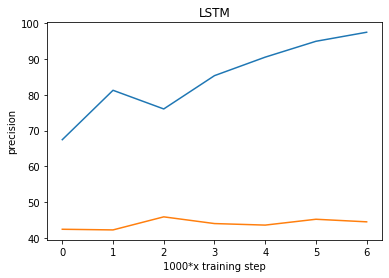

precision of the model on thevalidationdata: 45.561458587646484%
tensor([0.7470, 0.9636, 0.8268, 0.9988, 1.0000, 0.5761, 0.9785, 0.6280, 0.9850,
        0.7133, 0.6357, 0.6215, 0.9648, 1.0000, 0.9376, 1.0000, 0.9995, 0.6154,
        0.8940, 1.0000, 0.9999, 0.9999, 0.9948, 0.9738, 0.5526, 0.5733, 0.5458,
        1.0000, 0.5416, 0.5265, 0.6572, 0.9976, 0.9795, 0.9990, 0.9530, 0.7740,
        0.9982, 1.0000, 0.7519, 1.0000, 1.0000, 1.0000, 0.7674, 0.8692, 0.8698,
        0.9809, 0.9977, 0.9977, 0.5797, 0.6061, 0.5608, 0.9993, 0.9107, 1.0000,
        0.8914, 0.9977, 0.6459, 0.5078, 0.8875, 1.0000, 1.0000, 0.9919, 0.9998,
        0.9992, 0.9992, 0.9818, 0.5980, 0.5866, 0.5099, 0.9287, 1.0000, 0.9995,
        0.6192, 0.5778, 0.5084, 0.5598, 0.5105, 0.5817, 0.6434, 0.9260, 0.7388,
        0.9997, 0.7694, 0.9984, 0.9917, 0.5649, 0.6988, 0.9441, 0.8743, 0.6665,
        0.6708, 0.5474, 0.8026, 0.9897, 0.9989, 0.9765, 0.9683, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 44
Filte

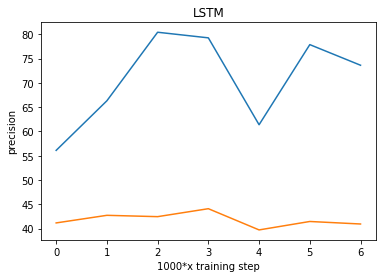

precision of the model on thevalidationdata: 43.1252555847168%
tensor([0.9369, 0.8941, 0.9920, 0.6738, 0.6926, 0.6342, 0.7696, 0.5323, 0.5240,
        1.0000, 0.6410, 0.9999, 0.5030, 0.6572, 0.8511, 0.9784, 0.5299, 0.9157,
        0.7036, 0.6575, 0.5270, 0.5377, 0.7662, 0.5155, 1.0000, 0.8376, 0.5754,
        0.5469, 0.6014, 0.6711, 0.5153, 0.8844, 0.5324, 0.9999, 0.9821, 1.0000,
        0.8683, 0.5623, 0.5293, 0.5324, 0.5324, 0.5266, 0.5235, 0.5320, 0.5325,
        0.9972, 1.0000, 1.0000, 0.5157, 0.5328, 0.5324, 0.5507, 0.5824, 0.5131,
        0.9405, 0.7019, 0.9610, 0.5203, 0.5466, 0.5320, 0.9223, 0.9298, 0.7489,
        0.9952, 0.9992, 0.7577, 0.5777, 0.5384, 0.5733, 0.5153, 0.5324, 0.5324,
        0.5545, 0.5366, 0.5607, 0.5192, 0.5155, 0.6281, 0.6573, 0.5320, 0.5325,
        0.5326, 0.5712, 0.5993, 0.5491, 0.5224, 0.5263, 0.5337, 0.5043, 0.5845,
        0.6096, 0.8617, 0.9998, 1.0000, 1.0000, 0.6478, 0.8038, 0.9022, 0.9958,
        0.8235], device='cuda:1')
current i is 45
Filter 

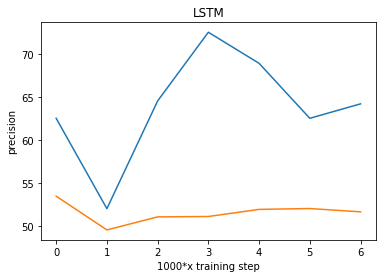

precision of the model on thevalidationdata: 51.43471908569336%
tensor([0.9918, 0.8305, 0.7160, 0.9986, 0.8996, 1.0000, 0.9767, 0.9884, 0.9996,
        0.9986, 0.9990, 0.6997, 0.9368, 0.9797, 0.8226, 0.7485, 0.8073, 0.8801,
        0.5333, 0.9519, 0.5338, 0.9995, 1.0000, 1.0000, 0.8119, 0.5816, 0.6826,
        0.9986, 0.9332, 0.9754, 0.9997, 0.9944, 0.8968, 0.9359, 0.9057, 0.7244,
        0.9996, 1.0000, 0.9999, 0.7753, 0.9290, 0.6692, 0.9678, 0.9985, 0.9993,
        1.0000, 0.9680, 0.9961, 0.9280, 0.9407, 0.6202, 0.9999, 0.9967, 0.9996,
        0.9919, 0.5988, 0.7359, 0.5621, 0.7825, 0.8159, 0.5835, 0.6237, 0.9216,
        0.9573, 0.8218, 0.9617, 0.9149, 0.6770, 0.9271, 0.9991, 0.9964, 0.9999,
        0.7008, 0.9933, 0.9983, 0.6583, 0.9153, 0.9998, 0.9998, 0.9999, 0.9670,
        1.0000, 0.9893, 0.9126, 0.9922, 0.7526, 0.7603, 0.9542, 0.9642, 0.9887,
        0.9556, 0.8443, 0.9996, 1.0000, 1.0000, 0.9966, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 46
Filter

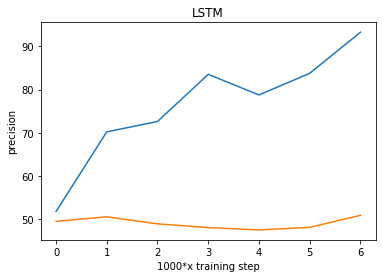

precision of the model on thevalidationdata: 51.13821029663086%
tensor([0.5898, 0.6140, 0.6565, 0.9542, 0.9914, 0.9995, 0.6584, 0.7457, 0.7176,
        0.5462, 0.5711, 0.5110, 0.6949, 0.6949, 0.5979, 0.9793, 1.0000, 0.6350,
        0.6311, 0.6129, 0.5638, 0.6949, 0.7496, 0.5998, 0.6223, 0.9250, 0.7975,
        0.5202, 0.6305, 0.5604, 0.6172, 0.6182, 0.5214, 0.8088, 0.8959, 1.0000,
        1.0000, 0.6949, 0.6559, 0.6836, 0.5689, 0.5690, 0.5414, 0.5650, 0.6427,
        0.5567, 0.6073, 0.6597, 0.5966, 0.7030, 0.7151, 0.8889, 0.5810, 0.5857,
        0.5424, 0.6058, 0.6456, 0.5627, 0.6948, 0.6939, 0.6954, 0.5455, 0.5119,
        0.5115, 0.7566, 0.6346, 0.7477, 0.6014, 0.5830, 0.5643, 0.6471, 0.6552,
        0.6590, 0.7196, 0.6904, 0.5494, 0.6960, 0.7883, 0.6777, 0.5556, 0.5608,
        0.6729, 0.6015, 0.5974, 0.6069, 0.6936, 0.6953, 0.6940, 0.7740, 0.5747,
        0.5925, 0.5986, 0.6237, 0.6218, 0.6018, 0.7768, 0.6006, 0.6173, 0.6355,
        0.6011], device='cuda:1')
current i is 47
Filter

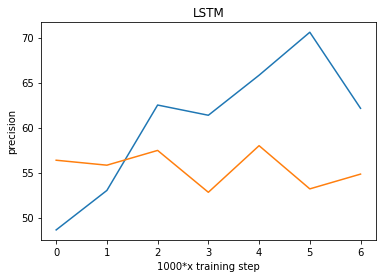

precision of the model on thevalidationdata: 55.09434127807617%
tensor([1.0000, 0.8452, 0.9989, 0.5988, 0.9993, 1.0000, 0.9908, 0.5019, 0.6800,
        1.0000, 0.9998, 1.0000, 0.6140, 0.9998, 1.0000, 0.6641, 0.9986, 0.6965,
        0.5260, 0.9973, 0.7067, 0.9998, 0.5206, 0.5980, 1.0000, 0.9983, 1.0000,
        0.5566, 0.9450, 0.9999, 0.8886, 0.9973, 0.9872, 1.0000, 0.5801, 1.0000,
        0.9997, 0.9975, 0.9999, 1.0000, 1.0000, 1.0000, 0.9623, 0.7537, 0.7010,
        0.6266, 0.9999, 0.9582, 0.8216, 0.5164, 0.7371, 1.0000, 1.0000, 1.0000,
        0.9946, 1.0000, 0.6829, 0.6065, 0.5366, 1.0000, 0.9713, 0.9996, 0.9971,
        0.9998, 0.9208, 0.9951, 0.9998, 0.6359, 0.8638, 1.0000, 0.9997, 0.5429,
        0.5332, 0.9601, 0.6029, 0.8736, 0.9110, 0.9992, 0.6601, 0.9990, 0.9719,
        0.9975, 0.9999, 0.5233, 0.9972, 0.9826, 1.0000, 0.9705, 0.5929, 0.9988,
        0.8937, 0.8270, 0.9925, 0.5947, 0.9999, 0.9786, 0.9031, 0.5143, 0.7973,
        0.9956], device='cuda:1')
current i is 48
Filter

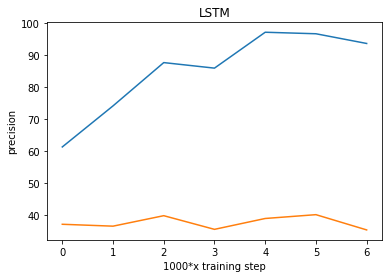

precision of the model on thevalidationdata: 35.01456832885742%
tensor([0.9195, 0.9215, 0.9732, 1.0000, 0.9997, 1.0000, 0.5125, 0.5125, 0.5124,
        0.5227, 0.5154, 0.5781, 0.6006, 0.5610, 0.9403, 0.5997, 0.6524, 0.6821,
        1.0000, 0.6162, 1.0000, 0.5125, 0.6760, 0.9923, 0.5126, 0.5141, 0.5099,
        0.5124, 0.5125, 0.5125, 0.5197, 0.5047, 0.5001, 0.5125, 0.5125, 0.5125,
        0.5818, 1.0000, 1.0000, 0.5101, 0.5766, 0.5711, 0.6730, 1.0000, 1.0000,
        0.5125, 0.5125, 0.5125, 0.5158, 0.5063, 0.5021, 1.0000, 0.5240, 1.0000,
        1.0000, 0.9912, 0.8920, 0.5444, 0.5451, 0.5673, 0.5125, 0.5125, 0.5125,
        0.5123, 0.5233, 0.7357, 1.0000, 1.0000, 1.0000, 0.9721, 0.9776, 0.9982,
        0.5125, 0.5124, 0.5149, 0.9990, 1.0000, 0.9998, 1.0000, 1.0000, 0.5925,
        0.5299, 0.5787, 0.6009, 0.5314, 0.5356, 0.5193, 1.0000, 0.6347, 0.9202,
        0.9350, 0.9973, 0.8178, 0.9995, 0.5125, 0.5357, 0.5354, 0.9619, 0.9998,
        0.9961], device='cuda:1')
current i is 49
Filter

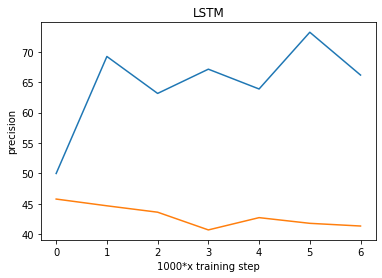

precision of the model on thevalidationdata: 41.24228286743164%
tensor([0.5389, 0.5836, 0.6751, 0.9503, 0.5688, 0.5263, 0.5329, 0.5538, 0.5617,
        0.5772, 0.5739, 0.5806, 0.8413, 0.8945, 0.9715, 0.6380, 0.6827, 0.9424,
        0.5063, 0.5482, 0.5347, 0.9999, 0.5275, 0.7008, 0.5308, 0.5560, 0.5603,
        0.5002, 0.9696, 0.6814, 0.5567, 0.6269, 0.7237, 0.5084, 0.6089, 0.5551,
        0.5236, 0.5694, 0.6811, 0.5638, 0.6963, 0.5847, 0.6589, 0.9216, 0.7723,
        0.5262, 0.5351, 0.7679, 0.9904, 0.9522, 0.9392, 0.5068, 0.5611, 0.5646,
        0.6297, 0.9171, 0.8593, 0.6709, 0.7738, 0.8936, 0.5796, 0.5763, 0.5456,
        0.5645, 0.5814, 0.5516, 0.5731, 0.5271, 0.5606, 0.5118, 0.7362, 0.7823,
        0.6994, 0.5421, 0.9195, 0.5199, 0.5889, 0.7520, 0.8390, 0.9714, 0.9997,
        0.9999, 0.9987, 0.9999, 0.5563, 0.5632, 0.6088, 0.9997, 0.5095, 0.6326,
        0.5517, 0.5225, 0.6277, 0.9792, 0.9954, 0.9954, 0.7759, 0.5945, 0.5396,
        0.5322], device='cuda:1')
current i is 50
Filter

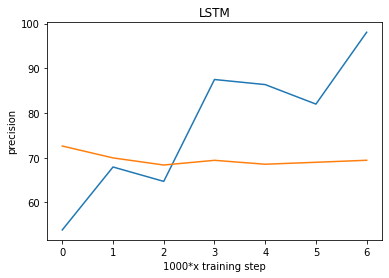

precision of the model on thevalidationdata: 68.67185974121094%
tensor([0.9995, 1.0000, 0.9677, 1.0000, 0.9996, 1.0000, 0.9999, 0.6215, 0.9986,
        1.0000, 0.5535, 1.0000, 0.5309, 1.0000, 1.0000, 1.0000, 0.9960, 1.0000,
        0.9930, 0.9994, 1.0000, 0.9605, 0.8743, 0.9995, 0.9852, 1.0000, 1.0000,
        0.9991, 1.0000, 0.9225, 0.9927, 0.9872, 0.9762, 0.9992, 1.0000, 0.9646,
        0.9975, 0.9995, 0.9916, 1.0000, 0.9868, 0.9298, 0.9039, 0.5732, 1.0000,
        1.0000, 0.9994, 1.0000, 0.9981, 0.9999, 1.0000, 0.9912, 0.9999, 0.5053,
        0.5768, 0.5342, 0.9127, 1.0000, 1.0000, 1.0000, 0.9902, 0.9943, 0.8041,
        1.0000, 0.9990, 1.0000, 0.9998, 0.9940, 0.7054, 0.9999, 0.9987, 0.9997,
        0.9847, 0.9988, 0.9999, 0.9352, 0.8796, 1.0000, 0.7952, 0.9473, 0.9992,
        1.0000, 0.8818, 0.7684, 0.9976, 0.9968, 0.6999, 0.9267, 0.9997, 1.0000,
        1.0000, 0.9951, 1.0000, 0.6707, 1.0000, 0.9998, 1.0000, 1.0000, 1.0000,
        0.9735], device='cuda:1')
current i is 51
Filter

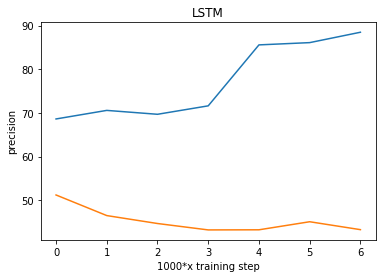

precision of the model on thevalidationdata: 44.7728271484375%
tensor([0.5299, 0.5798, 0.9591, 0.6954, 0.5627, 0.6707, 0.6771, 0.8802, 0.5151,
        0.9915, 0.5642, 0.6189, 0.7408, 0.9648, 0.6082, 0.8865, 0.5182, 0.8572,
        0.6748, 0.6315, 0.5383, 0.5116, 0.5775, 0.5359, 0.9819, 0.9844, 0.9818,
        1.0000, 0.9955, 0.7500, 0.9939, 0.9999, 0.5564, 0.5229, 0.6072, 0.9813,
        0.9985, 1.0000, 0.8984, 0.9151, 0.6671, 0.6474, 0.5670, 0.5842, 0.5650,
        0.5325, 0.9929, 0.9999, 0.8101, 0.9899, 0.5800, 0.5123, 0.9040, 0.9500,
        0.5069, 0.7670, 0.7181, 0.6614, 0.6684, 0.5540, 0.5019, 1.0000, 0.5372,
        0.5436, 0.5503, 0.5064, 0.5497, 0.6783, 0.5962, 0.9409, 0.8901, 0.6971,
        0.5833, 0.5613, 0.5352, 0.5627, 0.5236, 0.7401, 0.5503, 0.5629, 0.7439,
        0.6130, 0.5125, 0.5876, 0.9705, 0.8469, 0.9986, 0.9983, 0.5447, 0.8359,
        0.5885, 0.8721, 0.5564, 0.9737, 0.9189, 0.7547, 0.5061, 0.5504, 0.5012,
        0.6099], device='cuda:1')
current i is 52
Filter 

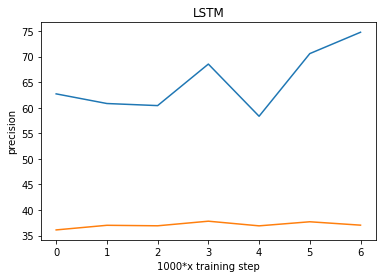

precision of the model on thevalidationdata: 36.71316909790039%
tensor([1.0000, 0.6074, 0.9350, 1.0000, 1.0000, 0.9986, 0.6565, 0.6015, 0.7580,
        0.9981, 1.0000, 0.9722, 1.0000, 1.0000, 0.9999, 0.9975, 1.0000, 0.9549,
        0.5078, 0.5969, 0.6686, 0.7063, 0.5542, 0.9752, 0.9600, 1.0000, 0.9958,
        1.0000, 1.0000, 0.7163, 0.5963, 0.5050, 0.7348, 0.9997, 0.9926, 0.9857,
        0.9999, 0.8283, 0.9868, 0.7050, 0.6286, 0.5127, 0.7902, 0.5832, 0.5810,
        0.5752, 0.5636, 0.6424, 0.9721, 0.9982, 1.0000, 1.0000, 0.9963, 0.9999,
        0.9230, 0.9478, 0.8788, 0.9959, 1.0000, 1.0000, 0.9991, 0.9740, 0.7260,
        0.9490, 0.6675, 0.5355, 0.5910, 0.6791, 0.6816, 0.5515, 0.5784, 0.7380,
        0.6580, 0.5261, 0.5536, 0.5682, 0.5738, 0.7342, 0.6824, 0.6421, 0.9684,
        0.9788, 0.8312, 0.6822, 0.5158, 1.0000, 1.0000, 0.9995, 0.9979, 0.9994,
        1.0000, 0.5375, 0.7578, 0.9954, 0.7104, 0.5080, 0.5228, 1.0000, 1.0000,
        1.0000], device='cuda:1')
current i is 54
Filter

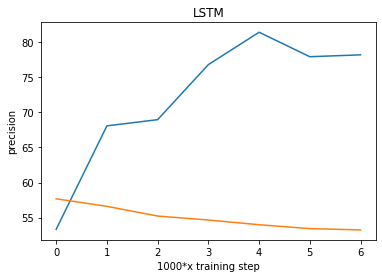

precision of the model on thevalidationdata: 53.68956756591797%
tensor([0.9981, 0.9999, 0.7958, 1.0000, 0.5142, 0.7856, 0.7521, 0.9958, 0.9985,
        1.0000, 0.9973, 1.0000, 0.6999, 0.9654, 0.6447, 0.9995, 0.5934, 0.9828,
        0.8947, 0.8493, 0.5864, 0.7367, 0.9869, 0.6292, 0.5567, 0.9983, 0.9847,
        0.9999, 0.5500, 0.5525, 0.9329, 0.8344, 0.6792, 0.5621, 0.7039, 1.0000,
        0.9784, 0.9941, 0.9878, 0.9995, 0.9935, 0.6685, 0.6697, 0.5539, 0.9999,
        1.0000, 1.0000, 1.0000, 0.5429, 0.6249, 0.9992, 1.0000, 0.9976, 0.7870,
        0.6915, 0.5694, 0.7414, 0.6526, 0.7530, 0.5522, 0.6610, 0.8400, 0.5674,
        0.5420, 0.6462, 0.9858, 1.0000, 0.7430, 1.0000, 0.6812, 0.9959, 0.5820,
        0.6468, 0.8984, 1.0000, 0.5484, 0.9979, 1.0000, 1.0000, 0.9981, 0.8732,
        0.5243, 1.0000, 0.9838, 0.5673, 1.0000, 1.0000, 0.5304, 0.6689, 0.9994,
        0.9761, 0.6830, 0.9739, 0.6568, 0.5770, 0.5561, 1.0000, 0.7853, 0.6411,
        1.0000], device='cuda:1')
current i is 55
Filter

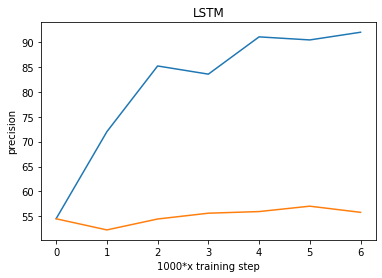

precision of the model on thevalidationdata: 56.863807678222656%
tensor([0.9994, 1.0000, 0.9989, 0.9316, 1.0000, 1.0000, 0.9931, 0.9513, 0.9931,
        0.9996, 0.9997, 1.0000, 0.9228, 1.0000, 0.9963, 0.6560, 1.0000, 1.0000,
        0.9180, 0.9136, 0.9999, 0.7238, 0.9998, 0.9953, 1.0000, 1.0000, 0.9980,
        0.9984, 0.9954, 0.5640, 0.6147, 0.9994, 0.9164, 0.5646, 0.9952, 0.9877,
        0.6619, 1.0000, 0.9871, 0.9916, 1.0000, 1.0000, 0.7969, 0.9670, 0.6652,
        0.9912, 1.0000, 0.9999, 0.5195, 0.9985, 0.7533, 0.6468, 1.0000, 0.9659,
        0.9983, 0.5627, 0.9809, 1.0000, 1.0000, 1.0000, 0.7722, 0.6733, 1.0000,
        1.0000, 1.0000, 1.0000, 0.8695, 0.6722, 0.9975, 0.6468, 1.0000, 0.9992,
        0.9985, 0.9999, 1.0000, 1.0000, 0.9994, 0.9999, 0.7781, 0.9804, 0.9946,
        0.9940, 1.0000, 0.9999, 0.5031, 1.0000, 0.9765, 0.9794, 0.9386, 0.7943,
        0.7275, 0.5125, 1.0000, 1.0000, 0.9999, 0.8155, 0.9916, 0.9213, 0.5517,
        1.0000], device='cuda:1')
current i is 56
Filte

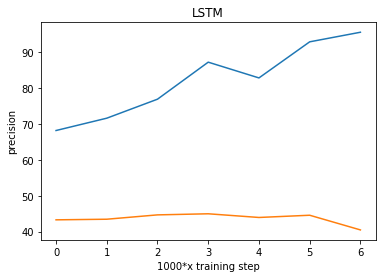

precision of the model on thevalidationdata: 45.304779052734375%
tensor([0.6167, 0.5491, 1.0000, 0.5975, 0.6029, 0.9985, 0.9865, 0.5667, 0.9991,
        0.9698, 0.6781, 0.9999, 0.9996, 0.9959, 1.0000, 0.9988, 1.0000, 0.9143,
        0.8400, 0.5556, 0.8858, 1.0000, 0.9232, 0.9788, 0.8328, 0.9410, 0.9999,
        0.9949, 0.7730, 0.7196, 0.9225, 0.9999, 0.9746, 1.0000, 0.9706, 0.9233,
        1.0000, 0.9997, 0.9960, 0.9762, 1.0000, 0.6599, 0.7728, 0.9581, 0.9923,
        0.6173, 1.0000, 0.8874, 0.9735, 0.5484, 0.6347, 1.0000, 0.9043, 0.9998,
        1.0000, 0.6260, 0.5775, 1.0000, 0.6825, 0.5552, 0.7500, 1.0000, 0.9991,
        0.7210, 0.9937, 0.9915, 0.5801, 0.9951, 0.8710, 0.9571, 0.8098, 0.9997,
        0.9997, 0.5827, 0.9999, 0.9443, 0.5943, 0.9991, 0.6349, 0.8119, 0.6637,
        1.0000, 0.6868, 0.9989, 0.9911, 0.9997, 0.9294, 0.5506, 0.9953, 1.0000,
        0.9874, 0.8291, 0.6586, 0.9999, 1.0000, 1.0000, 0.9836, 0.9745, 0.9332,
        0.9925], device='cuda:1')
current i is 57
Filte

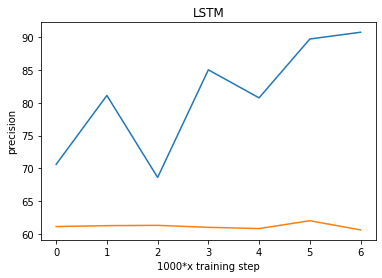

precision of the model on thevalidationdata: 60.20015335083008%
tensor([0.5033, 0.5484, 0.5200, 0.9548, 0.9999, 0.6281, 0.8224, 0.5901, 0.5103,
        0.6240, 0.6341, 0.6439, 0.9439, 0.9984, 0.9972, 0.5896, 0.5490, 0.5143,
        0.9943, 0.9815, 0.7887, 0.6623, 0.9579, 0.8957, 0.5238, 0.5666, 0.5392,
        0.9863, 0.9845, 0.8543, 0.5665, 0.5036, 0.5722, 0.5899, 0.5584, 0.5158,
        0.9991, 0.9951, 0.9999, 0.5643, 0.9495, 0.9980, 0.6611, 0.8009, 0.9587,
        0.5058, 0.5844, 0.5428, 0.5401, 0.5435, 0.5524, 0.5856, 0.5532, 0.5988,
        0.5289, 0.5852, 0.6468, 0.6210, 0.5756, 0.5613, 0.5300, 0.5348, 0.5880,
        0.5898, 0.8250, 0.9056, 0.9576, 0.6081, 0.5323, 0.5512, 0.8649, 0.5350,
        0.5653, 0.5300, 0.5286, 0.6334, 0.5784, 0.5832, 0.5425, 0.5532, 0.5657,
        0.5100, 0.5535, 0.5578, 0.9894, 1.0000, 0.9997, 0.8080, 0.7261, 0.9888,
        0.5883, 0.5500, 0.6550, 0.6427, 0.7018, 0.5667, 0.9986, 0.9626, 0.8982,
        0.9913], device='cuda:1')
current i is 58
Filter

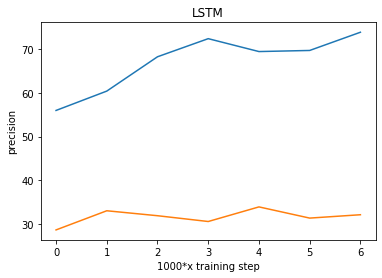

precision of the model on thevalidationdata: 32.28223419189453%
tensor([0.6833, 0.9999, 1.0000, 0.9933, 1.0000, 0.7942, 1.0000, 0.9998, 1.0000,
        0.9990, 0.6901, 1.0000, 0.9996, 0.9017, 0.9227, 0.9999, 0.9666, 0.9971,
        0.9931, 0.5495, 0.6465, 0.8378, 0.5361, 0.9995, 0.5572, 0.9986, 0.6431,
        0.9913, 0.9961, 0.9999, 0.9965, 0.9991, 0.8427, 0.7132, 0.5390, 0.9854,
        0.9999, 1.0000, 1.0000, 0.9995, 0.9999, 0.9977, 0.9989, 1.0000, 0.8687,
        0.9991, 0.6812, 1.0000, 0.8244, 0.9991, 0.9749, 0.8503, 0.9829, 0.9998,
        0.5730, 0.8210, 0.9942, 0.9891, 0.5400, 1.0000, 0.9999, 1.0000, 0.9270,
        0.5137, 0.6849, 0.9921, 0.9958, 0.9843, 0.5378, 0.5097, 0.5802, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9948, 0.8501, 1.0000, 0.9995, 1.0000, 0.6324,
        0.5698, 0.6868, 0.8157, 0.6481, 0.5337, 0.9995, 0.5825, 0.8982, 1.0000,
        0.7425, 0.5067, 0.6756, 0.9999, 1.0000, 0.9911, 0.6477, 0.6122, 0.7097,
        0.7456], device='cuda:1')
current i is 59
Filter

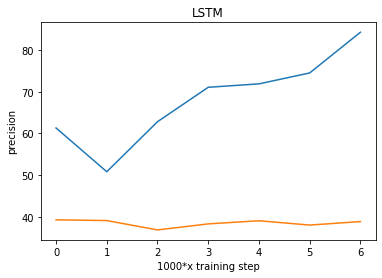

precision of the model on thevalidationdata: 38.2155647277832%
tensor([0.9999, 0.6973, 0.6309, 0.7419, 0.9943, 0.9897, 0.6053, 0.5790, 0.5308,
        0.5225, 0.5634, 0.6170, 0.9969, 0.5458, 0.8634, 0.9383, 0.8826, 0.9454,
        0.7881, 0.9912, 0.5283, 0.8492, 0.8789, 0.5987, 0.5726, 0.5202, 0.5009,
        0.9972, 0.5552, 0.9680, 0.7036, 0.6893, 0.6804, 0.5287, 0.5321, 0.7031,
        0.6324, 0.8091, 0.6478, 0.5477, 0.5994, 0.5848, 0.5566, 0.7502, 0.9456,
        0.5003, 0.6034, 0.5052, 0.9517, 1.0000, 0.8713, 0.5454, 0.5995, 0.5129,
        0.8693, 0.6925, 0.5825, 0.6584, 0.5665, 0.9064, 0.8765, 0.9998, 0.7740,
        0.6815, 0.9870, 0.7125, 0.5621, 0.5638, 0.5869, 0.5969, 0.6344, 1.0000,
        0.9986, 0.6610, 0.8400, 0.8511, 0.8745, 0.7694, 0.9981, 0.9363, 0.5113,
        0.5170, 0.5176, 0.8345, 0.7454, 0.9949, 0.6436, 0.5697, 0.5204, 0.5066,
        0.5034, 0.5042, 0.7097, 0.6352, 0.7005, 0.7903, 0.8169, 0.6520, 0.8014,
        0.6470], device='cuda:1')
current i is 60
Filter 

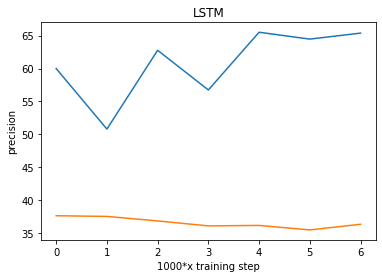

precision of the model on thevalidationdata: 35.774513244628906%
tensor([0.9989, 0.9998, 1.0000, 0.9654, 0.9952, 0.8440, 0.9897, 0.9625, 0.7196,
        0.9247, 0.9893, 0.6678, 0.6082, 0.8274, 0.5795, 0.5509, 0.6149, 0.5536,
        0.6192, 0.6258, 0.5849, 0.5200, 0.6499, 0.7171, 0.6079, 0.6650, 0.7086,
        0.9662, 0.5844, 0.5621, 0.9794, 0.8846, 0.9999, 0.9556, 0.7395, 0.6690,
        0.9903, 1.0000, 0.9992, 0.9034, 0.5723, 0.6913, 0.6918, 0.9998, 0.9999,
        1.0000, 0.5518, 0.6187, 0.8498, 0.9995, 1.0000, 0.9921, 0.8981, 0.9966,
        0.9610, 0.8287, 0.8861, 0.9995, 0.9999, 0.7998, 1.0000, 0.5933, 0.9791,
        0.9515, 0.9185, 0.9933, 0.9848, 0.6005, 0.7948, 0.9662, 0.9940, 0.9858,
        0.9950, 0.9995, 0.9998, 0.6413, 0.5188, 0.6206, 0.7180, 0.5403, 0.6125,
        0.5927, 0.6388, 0.6352, 0.7981, 0.5782, 0.5144, 0.9509, 0.5892, 0.5359,
        0.5380, 0.5183, 0.5216, 0.6360, 1.0000, 0.9999, 0.9999, 0.8217, 0.9998,
        0.9969], device='cuda:1')
current i is 61
Filte

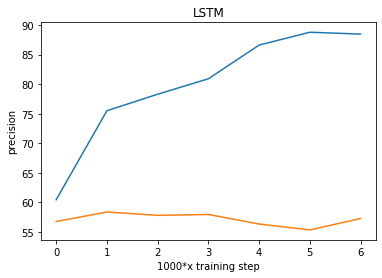

precision of the model on thevalidationdata: 57.47663497924805%
tensor([0.5150, 0.5136, 0.8789, 1.0000, 1.0000, 1.0000, 0.9259, 0.9645, 0.9988,
        0.9995, 0.9915, 1.0000, 0.5658, 0.7257, 0.5170, 1.0000, 0.9999, 1.0000,
        0.7570, 0.8072, 0.6938, 0.9998, 0.9713, 0.9859, 1.0000, 0.9993, 1.0000,
        1.0000, 1.0000, 1.0000, 0.7626, 0.9384, 1.0000, 0.9512, 0.7874, 0.8621,
        0.9971, 1.0000, 0.9771, 0.6953, 0.6779, 0.9171, 0.9993, 1.0000, 1.0000,
        0.6135, 0.9238, 1.0000, 0.5287, 0.5194, 1.0000, 0.6393, 1.0000, 0.9999,
        0.5807, 0.7527, 0.5768, 0.9497, 0.9923, 0.9780, 0.5391, 0.5250, 0.5819,
        0.7107, 0.9989, 1.0000, 0.7976, 1.0000, 1.0000, 0.9651, 1.0000, 1.0000,
        1.0000, 0.9943, 0.9999, 0.9994, 0.9977, 1.0000, 0.5264, 0.9962, 1.0000,
        0.6586, 0.9999, 0.9627, 1.0000, 0.7611, 1.0000, 1.0000, 0.9993, 1.0000,
        1.0000, 0.9880, 0.9785, 1.0000, 1.0000, 1.0000, 1.0000, 0.9951, 1.0000,
        0.5279], device='cuda:1')
current i is 62
Filter

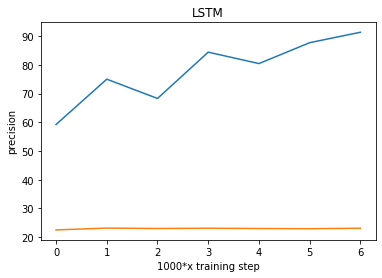

precision of the model on thevalidationdata: 22.892757415771484%
tensor([0.6384, 0.7927, 0.5716, 0.9993, 0.8421, 0.6139, 0.8339, 0.9994, 0.7824,
        0.9445, 0.6652, 0.5711, 0.9708, 0.8923, 0.9685, 0.9998, 0.9939, 0.9726,
        0.9795, 0.9269, 0.9985, 1.0000, 1.0000, 1.0000, 0.5051, 0.6605, 0.9855,
        0.9998, 0.9944, 1.0000, 0.5605, 0.5250, 0.8942, 0.9999, 0.9972, 0.9291,
        0.9363, 0.9113, 0.6992, 0.9600, 0.9997, 0.8062, 0.5781, 0.6120, 0.5602,
        0.9993, 0.5032, 0.6707, 0.9532, 0.9996, 1.0000, 0.9116, 0.7134, 0.8558,
        0.8991, 0.9786, 0.9350, 0.6994, 0.9781, 0.8971, 0.9475, 0.9973, 1.0000,
        0.9955, 0.9648, 0.5110, 0.5508, 0.9931, 1.0000, 0.9995, 0.8175, 0.5541,
        0.5883, 0.7074, 0.5799, 0.5044, 0.8323, 0.5173, 0.6268, 0.5434, 0.7551,
        0.7316, 0.8412, 0.5063, 0.6330, 0.6122, 0.9722, 0.9985, 0.9947, 0.9994,
        0.7420, 0.6877, 0.9929, 0.7047, 0.7734, 0.5872, 0.5709, 0.8459, 0.7569,
        0.6543], device='cuda:1')
current i is 63
Filte

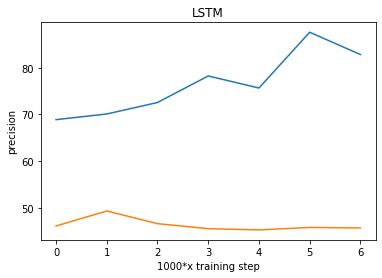

precision of the model on thevalidationdata: 44.901485443115234%
tensor([0.9947, 0.8381, 1.0000, 0.9983, 0.9894, 0.8014, 0.8989, 0.9970, 0.7535,
        0.9114, 0.9771, 0.9772, 0.7753, 0.9880, 0.9953, 0.9810, 0.5225, 0.9865,
        1.0000, 0.9997, 0.8362, 0.9850, 0.6562, 0.9395, 1.0000, 0.9879, 0.9467,
        1.0000, 0.9517, 0.7940, 0.9998, 0.8977, 0.9999, 0.8852, 0.8239, 0.9999,
        0.9992, 0.5995, 0.9999, 0.5809, 0.7654, 0.6101, 0.9995, 0.9316, 0.6985,
        0.9153, 0.5944, 0.5979, 1.0000, 0.7380, 1.0000, 0.7540, 0.5073, 0.5556,
        0.9989, 0.9856, 0.7844, 0.5053, 0.9999, 0.9501, 1.0000, 0.9247, 0.9993,
        0.6004, 0.6219, 0.8397, 0.7952, 0.9921, 1.0000, 1.0000, 0.9999, 1.0000,
        0.8761, 0.7372, 0.5755, 0.5436, 0.5309, 0.5774, 0.9998, 1.0000, 0.9996,
        0.9709, 0.5003, 0.6072, 0.9989, 0.9985, 1.0000, 0.7769, 0.7808, 0.5554,
        0.9454, 0.6409, 0.9949, 0.9977, 1.0000, 1.0000, 0.9318, 0.9998, 0.9980,
        0.8188], device='cuda:1')
current i is 64
Filte

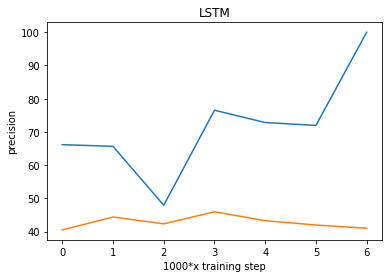

precision of the model on thevalidationdata: 41.628265380859375%
tensor([0.5272, 0.5317, 0.5489, 0.5168, 0.5176, 0.6632, 0.5190, 0.5554, 0.5482,
        0.5341, 0.5146, 0.6124, 0.5252, 0.5265, 0.5222, 0.5122, 0.5176, 0.5195,
        0.5176, 0.5176, 0.5176, 0.5176, 0.5453, 0.5649, 0.5272, 0.5006, 0.5184,
        0.5318, 0.5118, 0.5189, 0.5903, 0.5597, 0.5180, 0.5788, 0.5369, 0.5629,
        0.5176, 0.5175, 0.5177, 0.5127, 0.5176, 0.5176, 0.5683, 0.5176, 0.5177,
        0.5069, 0.5025, 0.9163, 0.8943, 0.5451, 0.8411, 0.6927, 0.9224, 0.5288,
        0.5408, 0.5184, 0.5180, 0.5172, 0.5177, 0.7268, 0.5153, 0.5347, 0.5199,
        0.5198, 0.5417, 0.5176, 0.5172, 0.5292, 0.5229, 0.5176, 0.5176, 0.5546,
        0.5675, 0.5202, 0.5202, 0.5199, 0.5155, 0.6528, 0.9924, 0.5707, 0.5521,
        0.5176, 0.5176, 0.5145, 0.5160, 0.5176, 0.5176, 0.5414, 0.5189, 0.5175,
        0.5176, 0.5175, 0.5176, 0.5176, 0.5831, 0.5176, 0.5176, 0.5923, 0.5302,
        0.5176], device='cuda:1')
current i is 65
Filte

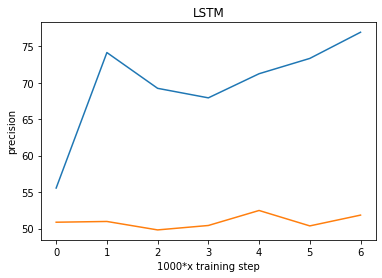

precision of the model on thevalidationdata: 51.578948974609375%
tensor([0.7056, 0.9183, 0.9256, 0.9990, 0.6467, 1.0000, 0.9998, 0.9999, 0.9995,
        0.9566, 0.9998, 0.9993, 1.0000, 1.0000, 0.9991, 0.9999, 0.9999, 0.8848,
        0.9988, 1.0000, 1.0000, 1.0000, 0.9981, 0.9995, 0.9965, 0.9990, 0.7523,
        0.9994, 1.0000, 1.0000, 0.9796, 0.9701, 0.9972, 0.9999, 0.8950, 0.8976,
        0.8268, 0.9996, 0.8719, 0.6451, 0.6640, 1.0000, 0.6805, 0.9988, 0.9890,
        0.9984, 0.6040, 0.9998, 0.5692, 0.8344, 0.9788, 0.9997, 0.9937, 1.0000,
        1.0000, 1.0000, 0.9999, 0.9874, 0.9999, 1.0000, 0.9973, 0.8702, 0.9998,
        0.9995, 0.9998, 1.0000, 0.9989, 1.0000, 0.9997, 0.9840, 0.9029, 0.9996,
        0.9937, 0.9990, 0.9993, 0.9389, 1.0000, 1.0000, 0.9997, 0.9303, 0.9474,
        0.9978, 0.8856, 1.0000, 0.9706, 0.9984, 1.0000, 0.5108, 0.7629, 0.8599,
        1.0000, 0.9996, 0.9963, 0.9872, 0.9990, 0.9757, 0.5404, 0.9714, 0.9279,
        0.9941], device='cuda:1')
current i is 66
Filte

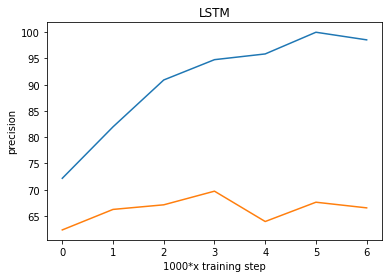

precision of the model on thevalidationdata: 67.8083267211914%
tensor([0.9996, 1.0000, 0.8901, 1.0000, 1.0000, 1.0000, 0.6789, 0.5641, 0.6873,
        0.5733, 0.5753, 0.5745, 1.0000, 0.9579, 1.0000, 0.5852, 0.5682, 0.5707,
        0.5738, 0.6211, 0.6008, 0.5443, 0.6171, 0.5610, 0.9836, 0.6638, 0.9624,
        0.5653, 0.5046, 0.5495, 0.5210, 0.9989, 1.0000, 0.6486, 0.5009, 0.6948,
        0.7511, 0.5184, 0.6704, 0.5989, 0.5588, 0.6110, 0.5774, 0.5756, 0.5686,
        0.5033, 0.6009, 0.5529, 0.5731, 0.5735, 0.5880, 0.9861, 0.5974, 0.9886,
        0.9161, 0.9966, 0.8345, 0.5719, 0.9487, 0.9998, 0.6093, 0.5586, 0.5030,
        0.5733, 0.5733, 0.5733, 0.9999, 1.0000, 0.9874, 0.5102, 0.5665, 0.5350,
        0.9989, 0.9998, 0.9551, 0.5044, 0.6056, 0.8199, 0.9990, 0.6296, 0.5556,
        0.5018, 0.5852, 0.6460, 0.5792, 0.5112, 0.5397, 0.5854, 0.5678, 0.5674,
        0.5734, 0.5020, 0.6055, 0.5742, 0.5745, 0.5727, 0.5769, 0.5950, 0.8997,
        0.5737], device='cuda:1')
current i is 67
Filter 

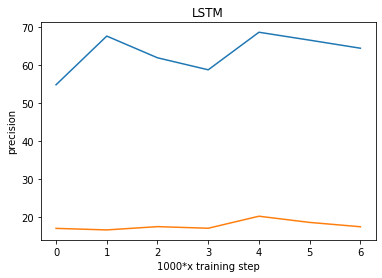

precision of the model on thevalidationdata: 17.663618087768555%
tensor([0.9990, 0.7312, 0.8123, 0.6586, 0.9789, 0.9118, 0.9291, 0.8094, 0.8559,
        0.9442, 0.7039, 0.9468, 0.6039, 0.5388, 0.5633, 0.9997, 0.9986, 0.5826,
        0.9105, 0.7164, 0.9723, 0.5238, 0.9996, 0.7949, 0.9917, 0.8575, 0.9787,
        0.6162, 0.5749, 0.8468, 0.5902, 0.5994, 0.9988, 0.7000, 0.8954, 0.9389,
        0.5157, 0.7377, 0.9792, 0.6767, 0.6018, 0.6008, 0.9997, 0.5863, 0.5260,
        0.6541, 0.5027, 0.8588, 0.9985, 0.5084, 0.9864, 0.5065, 0.5308, 0.5270,
        0.5690, 0.9982, 0.5098, 0.5651, 0.8302, 0.5934, 0.7257, 0.8388, 0.9998,
        0.5870, 0.8286, 0.7749, 0.9084, 0.9737, 0.6990, 0.7564, 0.5345, 0.5587,
        0.8824, 0.5143, 0.7324, 0.9998, 0.5934, 0.6431, 0.5397, 0.9842, 0.6423,
        0.9585, 0.7501, 0.5233, 0.5013, 0.6050, 0.9994, 0.7792, 0.9085, 0.5632,
        0.7037, 0.6959, 0.5422, 0.6661, 0.9965, 0.9391, 0.7567, 0.9967, 0.5864,
        0.5265], device='cuda:1')
current i is 68
Filte

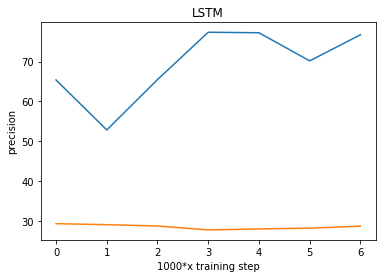

precision of the model on thevalidationdata: 28.118812561035156%
tensor([1.0000, 0.9999, 1.0000, 0.9998, 0.7020, 0.7596, 0.9835, 0.9999, 1.0000,
        0.9998, 0.8464, 0.9995, 0.9998, 1.0000, 1.0000, 0.6729, 0.9941, 0.9999,
        0.9949, 0.9994, 0.9999, 0.8087, 0.9999, 0.9878, 0.5378, 1.0000, 0.9130,
        0.5276, 0.5269, 0.8280, 1.0000, 0.9979, 0.7178, 0.5065, 0.9849, 0.9978,
        0.9997, 0.5059, 1.0000, 0.8308, 1.0000, 0.9802, 0.5415, 0.9933, 1.0000,
        0.9998, 0.9996, 1.0000, 0.6441, 0.6597, 0.6645, 0.9999, 0.9955, 0.9990,
        0.9553, 0.8418, 0.8579, 1.0000, 0.9923, 0.6243, 0.9973, 1.0000, 0.9911,
        0.6434, 0.9568, 0.5585, 0.9908, 0.9059, 0.6025, 0.6409, 0.9993, 1.0000,
        0.9998, 0.9445, 0.9956, 0.9998, 0.9999, 0.5010, 0.9975, 0.9991, 0.5153,
        0.9820, 0.9953, 0.9997, 1.0000, 0.9918, 1.0000, 1.0000, 0.9928, 0.6039,
        0.9879, 0.9972, 0.6488, 0.9874, 1.0000, 0.9991, 0.9303, 0.9959, 0.7700,
        0.9798], device='cuda:1')
current i is 69
Filte

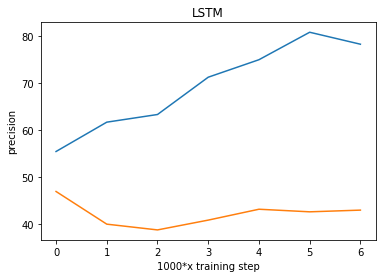

precision of the model on thevalidationdata: 43.792274475097656%
tensor([0.9999, 0.9927, 0.9983, 1.0000, 0.9964, 1.0000, 0.5746, 0.5743, 0.7267,
        0.7666, 0.6319, 1.0000, 0.9061, 1.0000, 0.9983, 0.9996, 1.0000, 0.9988,
        0.9482, 0.9428, 0.9296, 0.9253, 0.8130, 0.6599, 0.9997, 0.9998, 0.5943,
        0.6534, 0.9909, 0.9994, 0.9918, 0.7794, 1.0000, 0.9816, 0.8814, 0.9977,
        0.9551, 0.9930, 1.0000, 0.9442, 0.5679, 0.9897, 0.6410, 0.6401, 0.6074,
        0.9905, 1.0000, 1.0000, 0.7414, 0.5205, 0.6814, 0.9997, 0.9997, 1.0000,
        0.5545, 0.9042, 0.9456, 0.9505, 1.0000, 0.9505, 0.9991, 0.9975, 1.0000,
        0.9540, 0.6417, 0.9949, 0.9169, 0.9205, 0.9879, 0.7257, 0.7156, 0.9873,
        0.9933, 1.0000, 1.0000, 0.9997, 1.0000, 0.9983, 0.8186, 1.0000, 0.5943,
        0.9995, 1.0000, 0.9754, 0.7210, 0.6615, 0.9985, 0.7072, 0.8388, 0.9953,
        0.9971, 0.9392, 1.0000, 0.8752, 1.0000, 0.9984, 0.9699, 0.8064, 0.6475,
        0.9409], device='cuda:1')
current i is 70
Filte

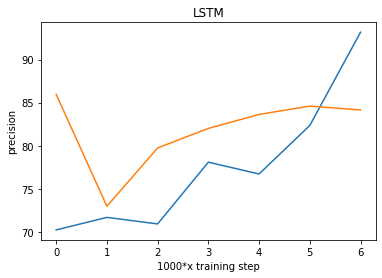

precision of the model on thevalidationdata: 85.4231948852539%
tensor([0.9997, 1.0000, 0.9561, 0.9991, 0.9988, 1.0000, 0.9903, 0.9998, 0.9365,
        0.9321, 0.7791, 1.0000, 0.8471, 0.6832, 0.9135, 0.6103, 0.9672, 1.0000,
        0.9957, 0.6261, 0.9911, 0.9998, 0.9263, 0.9999, 0.6720, 0.8394, 0.9999,
        1.0000, 1.0000, 0.9908, 1.0000, 0.7889, 1.0000, 0.8337, 0.9645, 0.9999,
        0.5095, 1.0000, 0.9888, 0.9720, 0.8956, 0.6159, 0.9997, 1.0000, 0.9962,
        0.9994, 0.9521, 0.7737, 1.0000, 1.0000, 0.9103, 0.9371, 1.0000, 0.9995,
        0.9528, 0.9992, 0.9981, 0.7565, 0.6813, 0.5395, 0.6920, 1.0000, 1.0000,
        1.0000, 0.9999, 1.0000, 0.9980, 0.9023, 0.6249, 0.6249, 0.9995, 1.0000,
        0.9946, 0.9998, 1.0000, 1.0000, 0.8394, 0.9988, 0.6876, 0.6475, 0.5689,
        0.9952, 1.0000, 0.8311, 1.0000, 0.9999, 1.0000, 1.0000, 0.7895, 0.9854,
        0.9994, 1.0000, 0.9908, 0.9999, 0.9994, 0.9976, 1.0000, 1.0000, 0.9479,
        0.5868], device='cuda:1')
current i is 71
Filter 

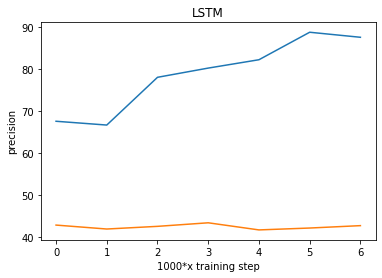

precision of the model on thevalidationdata: 42.89940643310547%
tensor([0.7574, 0.6915, 0.6157, 0.9841, 0.9401, 0.9735, 1.0000, 0.9499, 0.7445,
        0.5484, 0.6374, 0.5683, 0.9964, 0.8256, 0.7359, 0.8077, 0.9738, 0.9967,
        0.5724, 0.5364, 0.5833, 0.5332, 0.5596, 0.5328, 0.9998, 0.8657, 0.5453,
        0.6574, 0.6117, 0.6084, 0.9998, 0.9945, 0.9938, 0.9983, 1.0000, 0.9977,
        0.9998, 0.7390, 0.9993, 0.6804, 0.6390, 0.6806, 0.6955, 0.7673, 0.5617,
        1.0000, 1.0000, 0.9956, 0.5677, 0.5112, 0.5633, 0.5803, 0.5920, 0.6028,
        0.9183, 0.9584, 0.7086, 0.9716, 0.9417, 0.8734, 0.7577, 0.7565, 0.5891,
        0.9992, 0.9967, 0.9225, 0.5544, 0.5833, 0.5793, 0.8314, 0.8303, 0.6060,
        0.5708, 0.5363, 0.5630, 0.5713, 0.6406, 0.5525, 0.6012, 0.5755, 0.5488,
        0.9114, 0.9780, 0.8047, 0.9798, 0.9999, 0.9536, 0.7037, 0.6220, 0.6107,
        0.6584, 0.6536, 0.7322, 0.6275, 0.6188, 0.5031, 0.7633, 0.9567, 0.9863,
        0.5480], device='cuda:1')
current i is 72
Filter

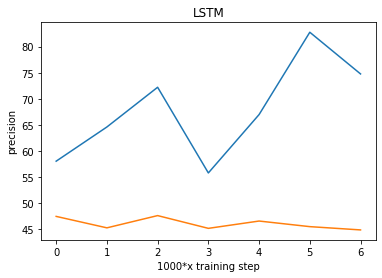

precision of the model on thevalidationdata: 45.55520248413086%
tensor([0.9884, 1.0000, 0.9238, 0.5384, 0.5743, 0.7989, 0.8530, 0.9325, 0.7090,
        0.8341, 0.7185, 0.7746, 0.5034, 0.9329, 0.9815, 0.9013, 0.9953, 0.9098,
        0.9924, 0.5702, 0.9941, 0.6721, 0.6806, 0.7796, 0.6458, 0.6655, 0.6525,
        0.9545, 0.7656, 0.9997, 0.9698, 0.8109, 0.6315, 0.9998, 0.9998, 0.9996,
        0.9997, 0.9999, 1.0000, 0.9999, 1.0000, 0.9888, 0.9989, 0.8471, 0.9549,
        0.9999, 0.8854, 0.9985, 0.8591, 0.6751, 0.7426, 0.6496, 0.5920, 0.6344,
        0.6339, 0.6663, 0.6419, 0.8906, 0.8256, 0.9053, 1.0000, 0.9716, 1.0000,
        0.5991, 0.6269, 0.6422, 0.8567, 0.6934, 0.8826, 0.9999, 0.9996, 0.9852,
        0.9893, 0.9725, 0.9922, 0.6237, 0.6136, 0.6161, 1.0000, 0.8898, 0.8489,
        0.7719, 0.6685, 0.5758, 1.0000, 0.9926, 0.9738, 0.9678, 0.8610, 0.7946,
        0.6170, 0.9999, 0.9164, 0.5507, 0.5770, 0.5870, 0.5623, 0.6043, 0.5985,
        0.5633], device='cuda:1')
current i is 73
Filter

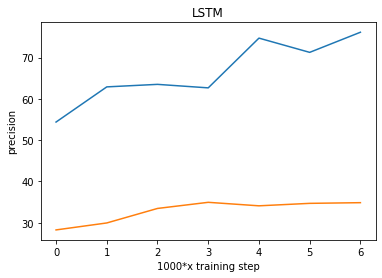

precision of the model on thevalidationdata: 36.03351974487305%
tensor([0.9999, 0.9999, 1.0000, 0.9536, 0.8250, 1.0000, 0.6965, 0.5723, 0.9979,
        0.9747, 0.7008, 0.6074, 0.5125, 0.5498, 0.9866, 0.9876, 0.5280, 0.5600,
        0.8557, 0.7694, 0.6665, 0.6981, 0.8011, 0.6124, 0.6882, 0.5680, 0.7299,
        0.5204, 0.6158, 0.5032, 0.7155, 0.6634, 0.9871, 0.7060, 0.5091, 0.5019,
        0.9873, 0.6376, 0.5517, 0.5079, 0.5539, 0.5277, 0.5356, 0.5261, 0.8635,
        0.9801, 0.5262, 0.5560, 0.6240, 0.5148, 0.9841, 0.5363, 0.9406, 0.8214,
        0.9997, 0.5596, 0.8503, 0.7497, 0.8209, 0.6600, 0.5241, 0.5239, 0.7780,
        0.5109, 0.9972, 0.7517, 1.0000, 0.8920, 0.6883, 0.8717, 0.7912, 0.9316,
        0.9992, 0.8767, 0.5500, 0.8616, 0.5598, 0.5489, 0.5928, 0.6525, 0.8932,
        0.8440, 0.5085, 0.7281, 0.9415, 0.8217, 0.6532, 0.6083, 0.8213, 0.7906,
        0.9023, 0.9223, 1.0000, 0.5641, 0.9999, 1.0000, 0.8343, 0.9943, 0.9990,
        0.8090], device='cuda:1')
current i is 74
Filter

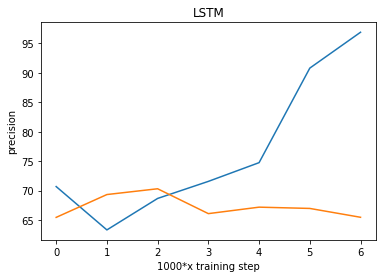

precision of the model on thevalidationdata: 65.61199188232422%
tensor([0.9793, 0.9987, 0.9441, 0.9999, 0.9633, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9496, 1.0000, 0.5250, 1.0000, 0.9955, 0.9999, 0.9967, 0.9985, 0.9229,
        1.0000, 0.9999, 1.0000, 1.0000, 0.9913, 0.9983, 0.9994, 0.6781, 0.9999,
        0.8601, 1.0000, 0.8728, 1.0000, 0.9994, 0.9661, 0.9845, 1.0000, 1.0000,
        1.0000, 0.9992, 0.9999, 0.8649, 0.9329, 0.7743, 0.9339, 1.0000, 1.0000,
        0.9651, 0.8885, 0.9140, 0.9991, 1.0000, 1.0000, 0.9863, 1.0000, 1.0000,
        0.9998, 1.0000, 1.0000, 1.0000, 0.5010, 0.9980, 0.9988, 0.9978, 1.0000,
        0.9936, 0.9997, 0.9960, 0.9786, 1.0000, 1.0000, 1.0000, 0.9577, 1.0000,
        1.0000, 0.9999, 1.0000, 0.6308, 0.9992, 1.0000, 0.9999, 0.9903, 1.0000,
        0.8540, 0.8655, 0.9698, 0.9928, 0.8721, 1.0000, 1.0000, 0.9960, 0.8720,
        0.9276, 0.9022, 0.9999, 0.9995, 0.9994, 0.9982, 0.9983, 0.8755, 1.0000,
        0.9996], device='cuda:1')
current i is 75
Filter

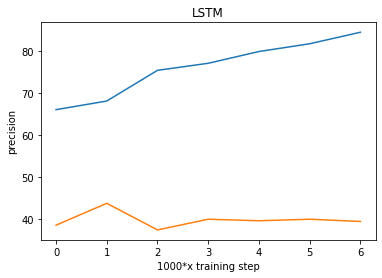

precision of the model on thevalidationdata: 40.06134796142578%
tensor([0.7698, 0.9991, 0.9953, 0.7851, 0.6675, 0.5238, 0.6141, 0.7761, 0.6317,
        0.5772, 0.7856, 0.7285, 0.5874, 0.6537, 0.5258, 0.5780, 0.8326, 0.7401,
        0.8435, 0.5402, 0.9363, 0.7369, 0.6544, 0.7094, 0.7625, 0.7091, 0.7598,
        0.7849, 0.7357, 0.8897, 0.6164, 0.5247, 0.7288, 0.8959, 0.7449, 0.8429,
        0.6859, 0.6888, 0.5900, 0.8714, 0.7517, 0.8826, 0.5390, 0.7970, 0.5960,
        0.5462, 0.5238, 0.6878, 0.8148, 0.6511, 0.8513, 0.7363, 0.5013, 0.6358,
        0.6517, 0.5319, 0.5207, 0.8440, 0.6368, 0.7540, 0.6106, 0.6201, 0.5091,
        0.5521, 0.6228, 0.5451, 0.5770, 0.5596, 0.7994, 0.6785, 0.5200, 0.8073,
        0.6335, 0.6260, 0.6807, 0.5189, 0.7382, 0.5870, 0.6239, 0.5188, 0.7607,
        0.6135, 0.7101, 0.9096, 0.6020, 0.6161, 0.6364, 0.8911, 0.8599, 0.7524,
        0.6811, 0.5031, 0.7507, 0.9988, 0.5274, 0.9816, 0.6936, 0.7797, 0.9076,
        0.5513], device='cuda:1')
current i is 76
Filter

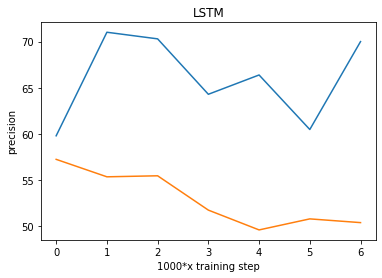

precision of the model on thevalidationdata: 52.05515670776367%
tensor([0.9998, 0.9009, 0.9899, 0.6957, 0.7707, 0.6172, 0.6139, 0.9667, 0.6239,
        0.5290, 0.5082, 0.5505, 0.5457, 0.5901, 0.5125, 0.5362, 0.6038, 0.7034,
        0.5211, 0.9482, 0.9619, 0.9890, 0.8276, 0.9531, 0.7792, 0.9619, 0.9909,
        0.5652, 0.5371, 0.5154, 0.9084, 0.8167, 0.9561, 0.6067, 0.5471, 0.5095,
        0.9700, 0.9973, 0.9160, 0.5493, 0.5056, 0.5665, 0.7667, 0.8173, 0.9889,
        0.6672, 0.5694, 0.7581, 0.5159, 0.5172, 0.5512, 0.8427, 0.9278, 0.9387,
        0.5259, 0.5190, 0.5711, 0.6054, 0.5287, 0.6751, 0.5501, 0.5811, 0.5687,
        0.9913, 0.6003, 0.9718, 0.7875, 0.9723, 0.9895, 0.6294, 0.7344, 0.6877,
        0.5757, 0.6640, 0.6460, 0.7401, 0.7261, 0.7949, 0.7517, 0.5152, 0.6269,
        0.6450, 0.9743, 0.8923, 0.9992, 0.6720, 0.5827, 0.7149, 0.5053, 0.6003,
        0.9499, 0.9961, 0.9907, 0.9807, 0.8908, 0.8128, 0.6810, 0.9722, 0.9086,
        0.9158], device='cuda:1')
current i is 77
Filter

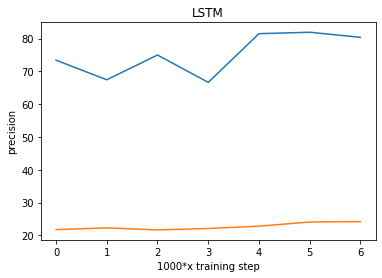

precision of the model on thevalidationdata: 24.502084732055664%
tensor([0.6159, 0.6903, 0.9055, 0.5569, 0.9498, 0.9973, 0.5919, 0.9167, 0.9991,
        0.9993, 0.7830, 0.8211, 0.9896, 0.5084, 0.9934, 0.9848, 0.9704, 0.6933,
        0.8497, 0.5309, 0.9658, 0.7096, 1.0000, 0.9829, 0.7141, 0.5377, 0.9444,
        0.5622, 0.6073, 0.9668, 0.9998, 0.5246, 0.9018, 0.9926, 0.9660, 0.5261,
        0.9339, 0.7944, 0.5499, 0.5462, 0.7338, 0.6214, 0.5229, 0.9166, 0.8064,
        0.5268, 0.8806, 0.6742, 0.7983, 0.5265, 0.8022, 0.5645, 0.5234, 0.9950,
        0.6561, 0.9885, 0.7743, 0.5095, 0.8444, 0.5026, 0.9899, 0.9722, 0.7415,
        0.5163, 0.8620, 0.6125, 0.7258, 0.8202, 0.5082, 0.9995, 0.7682, 0.6852,
        0.9173, 0.9995, 0.6255, 0.8360, 0.5070, 0.5340, 0.9569, 0.6155, 1.0000,
        0.9867, 0.9419, 0.8424, 0.9829, 0.5284, 0.7527, 0.5187, 0.6583, 0.5066,
        0.5561, 0.9983, 0.9721, 0.5273, 0.6115, 0.5072, 0.5348, 0.8794, 0.5454,
        0.7001], device='cuda:1')
current i is 78
Filte

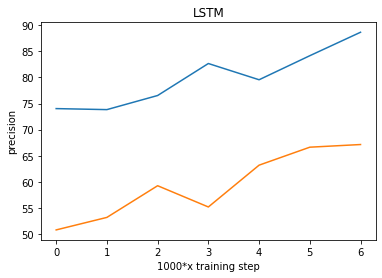

precision of the model on thevalidationdata: 65.79080200195312%
tensor([0.9999, 0.9733, 0.7799, 0.8518, 0.9141, 0.7752, 0.9646, 0.9992, 0.6096,
        0.5612, 0.5612, 0.5122, 0.5612, 0.5612, 0.7258, 0.5612, 0.5612, 0.7360,
        0.5613, 0.5611, 0.7885, 0.5611, 0.5609, 0.5802, 0.5609, 0.5611, 0.5456,
        0.5604, 0.5613, 0.5505, 0.5605, 0.5610, 0.7017, 0.5614, 0.5610, 0.5804,
        0.5612, 0.5065, 0.9156, 0.5614, 0.5610, 0.6541, 0.5612, 0.5612, 0.5126,
        0.5612, 0.5612, 0.6629, 0.5530, 0.5590, 0.5328, 0.9828, 0.7300, 0.5612,
        0.8359, 0.8407, 0.5930, 0.5577, 0.5618, 0.8016, 0.5612, 0.5612, 0.5654,
        0.9397, 0.9773, 0.5495, 0.5798, 0.8414, 0.6207, 0.7080, 0.5834, 0.6226,
        0.5612, 0.5612, 0.6178, 0.5778, 0.5802, 0.5586, 0.5609, 0.5606, 0.5610,
        0.5612, 0.5612, 0.6966, 0.5618, 0.5606, 0.6104, 0.5381, 0.5367, 0.6380,
        0.7568, 0.5526, 0.5591, 0.5620, 0.5614, 0.8007, 0.5610, 0.5607, 0.5579,
        0.5612], device='cuda:1')
current i is 80
Filter

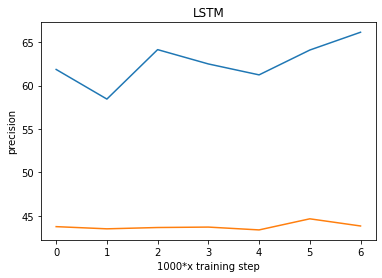

precision of the model on thevalidationdata: 44.73358154296875%
tensor([0.9217, 0.7125, 0.7593, 0.6325, 0.5273, 0.7473, 0.6909, 0.6593, 0.7480,
        0.7467, 0.8784, 0.8379, 0.8277, 0.6820, 0.7079, 0.9673, 0.6224, 0.6262,
        0.9881, 0.8506, 0.7130, 0.6367, 0.5830, 0.5496, 0.9965, 0.9313, 0.8097,
        0.9839, 0.7387, 0.7100, 0.7716, 0.8746, 0.5178, 0.8343, 0.9875, 0.7297,
        0.9295, 0.9637, 0.7177, 0.7195, 0.7359, 0.7119, 0.8834, 0.7117, 0.7230,
        0.6999, 0.7781, 0.6805, 0.5079, 0.7627, 0.5829, 0.6213, 0.9873, 0.6896,
        0.8186, 0.7928, 0.5041, 0.8111, 0.9780, 0.6906, 0.7262, 0.7173, 0.7180,
        0.7315, 0.9737, 0.8131, 0.9608, 0.5342, 0.8562, 0.7293, 0.6834, 0.7970,
        0.7913, 0.5035, 0.9738, 0.9556, 0.9673, 0.8881, 0.5251, 0.7950, 0.9861,
        0.7898, 0.9703, 0.9736, 0.8736, 0.8228, 0.9063, 0.8510, 0.7889, 0.9777,
        0.7052, 0.5858, 0.9210, 0.9355, 0.6310, 0.5205, 0.7283, 0.6930, 0.9745,
        0.8440], device='cuda:1')
current i is 81
Filter

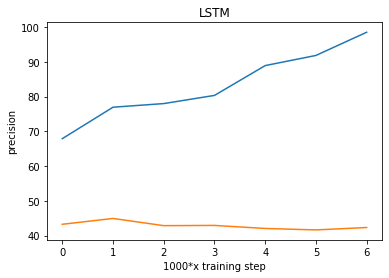

precision of the model on thevalidationdata: 41.4260139465332%
tensor([1.0000, 0.6974, 1.0000, 0.9999, 1.0000, 0.9634, 0.9999, 0.9729, 0.7262,
        0.5477, 1.0000, 0.9985, 0.9010, 0.9901, 0.9920, 0.6089, 0.6220, 0.6277,
        0.9827, 0.9993, 0.9588, 0.9198, 0.6477, 0.7623, 0.9990, 1.0000, 0.9999,
        0.6890, 0.7439, 0.7904, 0.5298, 0.9553, 0.9997, 0.5194, 0.6261, 0.7292,
        1.0000, 1.0000, 0.8518, 1.0000, 1.0000, 0.8859, 0.9644, 0.9994, 0.9531,
        0.9881, 0.9329, 1.0000, 0.5163, 0.6649, 0.5021, 0.7208, 0.9914, 1.0000,
        0.7530, 0.9962, 0.9825, 1.0000, 0.8766, 0.9942, 0.8157, 0.9999, 0.9303,
        0.9995, 0.9997, 0.9996, 0.9967, 0.9997, 0.9943, 0.9991, 0.8881, 0.9966,
        0.5605, 0.7041, 0.5964, 0.9637, 1.0000, 0.9201, 0.9999, 0.9912, 0.9986,
        0.9992, 0.9996, 0.9998, 1.0000, 1.0000, 0.9998, 1.0000, 0.5844, 1.0000,
        0.9939, 1.0000, 0.9994, 0.9999, 0.6609, 0.9024, 0.8934, 0.9425, 1.0000,
        1.0000], device='cuda:1')
current i is 83
Filter 

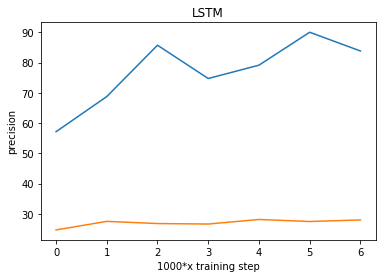

precision of the model on thevalidationdata: 29.931549072265625%
tensor([0.5544, 0.5772, 0.5885, 0.7270, 0.5054, 0.7438, 0.5140, 0.5632, 0.6060,
        0.6003, 0.5447, 0.5685, 0.6315, 0.5599, 0.6770, 0.6866, 0.7396, 0.5041,
        0.6281, 0.6828, 0.5654, 0.8475, 0.7628, 0.5550, 0.5309, 0.9740, 0.9974,
        0.5009, 0.8088, 0.5673, 0.7275, 0.5840, 0.7780, 0.7201, 0.8974, 0.5496,
        0.5365, 0.7154, 0.6387, 0.5569, 0.5506, 0.6007, 0.5585, 0.5806, 0.5850,
        0.5111, 0.8974, 0.5035, 0.5582, 0.6074, 0.5543, 0.9132, 0.6561, 0.6220,
        0.7300, 0.5463, 0.5777, 0.5691, 0.5532, 0.5731, 0.6600, 0.5420, 0.5689,
        0.6357, 0.7259, 0.5673, 0.5227, 0.6231, 0.5706, 0.5047, 0.9203, 0.6003,
        0.6248, 0.5794, 0.5674, 0.6074, 0.5284, 0.5662, 0.5770, 0.5663, 0.5305,
        0.5717, 0.5685, 0.5686, 0.5756, 0.5611, 0.9247, 0.5537, 0.5013, 0.5784,
        0.8868, 0.6136, 0.5980, 0.7427, 0.6987, 0.7012, 0.6710, 0.7569, 0.5706,
        0.7934], device='cuda:1')
current i is 84
Filte

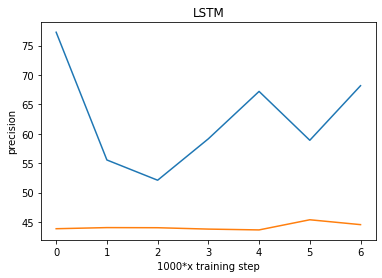

precision of the model on thevalidationdata: 44.5069580078125%
tensor([0.5113, 0.5154, 0.5338, 0.7546, 0.5274, 0.5422, 0.9588, 0.5809, 0.9975,
        0.8161, 0.6615, 0.9835, 0.6675, 0.7994, 0.9777, 0.5537, 0.7480, 0.8732,
        0.6296, 0.9766, 0.9726, 0.7226, 0.6345, 0.9997, 0.7612, 0.6605, 0.6891,
        0.7883, 0.5961, 0.8674, 0.5501, 0.5576, 0.8095, 0.8196, 0.6325, 0.8933,
        0.5112, 0.5919, 0.8216, 0.5284, 0.6812, 0.8843, 0.5021, 1.0000, 0.7863,
        0.9993, 0.9533, 1.0000, 0.7148, 0.6498, 0.7910, 0.5314, 0.6565, 0.8794,
        0.7338, 0.5517, 0.8763, 0.8618, 0.9810, 0.9975, 0.5617, 0.5996, 0.9212,
        0.5730, 0.5897, 0.7651, 0.6190, 0.5333, 0.9979, 0.5207, 0.5561, 0.7765,
        0.6157, 0.5432, 0.5629, 0.9847, 0.7839, 0.7627, 0.6332, 0.9172, 0.9925,
        0.9993, 0.9763, 0.5182, 0.6875, 0.6951, 0.6595, 0.9758, 0.9467, 0.6685,
        0.6040, 0.7097, 0.8512, 0.8516, 0.7533, 0.9749, 0.9999, 0.9998, 0.7479,
        0.6186], device='cuda:1')
current i is 85
Filter 

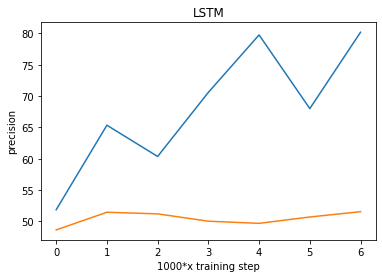

precision of the model on thevalidationdata: 50.93366622924805%
tensor([0.9862, 0.8630, 0.9459, 0.8605, 0.8945, 0.9831, 0.6430, 0.6034, 0.5193,
        0.8822, 0.5535, 0.6297, 0.5101, 0.5680, 0.5794, 0.6502, 0.5327, 0.7115,
        0.5147, 0.5607, 0.5185, 0.9859, 0.8476, 0.9935, 0.5658, 0.7218, 0.5536,
        0.5819, 0.6456, 0.5501, 0.5967, 0.9366, 0.9820, 0.6437, 0.6566, 0.6966,
        0.9674, 0.7626, 0.5146, 0.5399, 0.5498, 0.5570, 0.7732, 0.5942, 0.5241,
        0.5439, 0.6018, 0.5033, 0.9933, 0.6822, 0.8287, 0.5563, 0.6234, 0.5055,
        0.5391, 0.6423, 0.6122, 0.6377, 0.8012, 0.5168, 0.6659, 0.9240, 0.8555,
        0.5830, 0.5495, 0.5062, 0.6083, 0.7525, 0.7364, 0.9645, 0.5194, 0.5194,
        0.5291, 0.5668, 0.5029, 0.5910, 0.5635, 0.5486, 0.9625, 0.9630, 0.7284,
        0.6007, 0.5296, 0.5951, 0.9760, 0.6278, 0.5308, 0.6386, 0.9065, 0.6110,
        0.6827, 0.8122, 0.5133, 1.0000, 0.9344, 0.6796, 0.5295, 0.6634, 0.7697,
        0.5166], device='cuda:1')
current i is 86
Filter

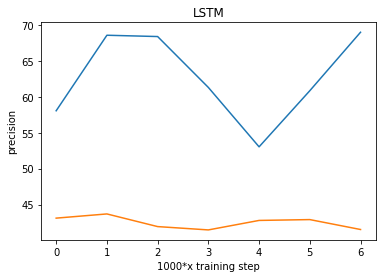

precision of the model on thevalidationdata: 45.238094329833984%
tensor([0.6010, 0.5529, 0.5297, 0.6339, 0.5866, 0.7197, 0.5815, 0.6933, 0.6859,
        0.6179, 0.5165, 0.6522, 0.5814, 0.6012, 0.6670, 0.6119, 0.9373, 0.9050,
        0.6327, 0.7156, 0.5976, 0.6253, 0.5369, 0.6117, 0.5165, 0.7217, 0.5648,
        0.9996, 0.6436, 0.9194, 0.8658, 0.8284, 0.6070, 0.5786, 0.7609, 0.8120,
        0.7190, 0.5038, 0.5125, 0.5709, 0.6283, 0.5533, 0.5248, 0.6872, 0.9991,
        0.6869, 0.5805, 0.6216, 0.6581, 0.5270, 0.5252, 0.6041, 0.5337, 0.8231,
        0.5454, 0.6803, 0.8637, 0.6864, 0.5342, 0.9156, 0.6267, 0.9792, 0.5593,
        0.6361, 0.5640, 0.5924, 0.5491, 0.7028, 0.9554, 0.6352, 0.5439, 0.7797,
        0.5833, 0.5722, 0.5962, 0.7937, 0.9512, 0.9622, 0.5011, 0.6835, 0.8824,
        0.9849, 0.6315, 0.6299, 0.7976, 0.5780, 0.5255, 0.7169, 0.5824, 0.5531,
        0.5457, 0.9535, 0.7190, 0.5470, 0.5836, 0.6760, 0.6922, 0.5968, 0.5020,
        0.5211], device='cuda:1')
current i is 87
Filte

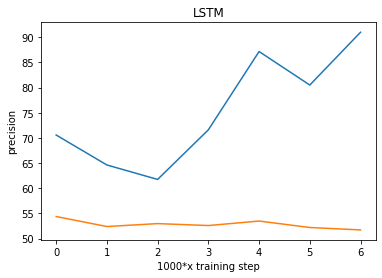

precision of the model on thevalidationdata: 52.31379318237305%
tensor([0.6875, 0.7739, 0.6211, 0.5251, 1.0000, 1.0000, 0.9999, 0.9220, 0.9800,
        0.5406, 0.5733, 0.6019, 0.9025, 0.7961, 0.8199, 0.5554, 0.6023, 0.6361,
        0.9968, 0.9972, 0.9972, 0.9311, 0.9998, 1.0000, 1.0000, 0.7084, 1.0000,
        0.9990, 0.6144, 0.9400, 0.7029, 0.5475, 0.8952, 1.0000, 0.8832, 1.0000,
        0.5617, 0.5666, 0.9415, 0.9997, 0.7815, 0.5747, 0.9664, 0.5388, 0.9564,
        0.9999, 0.9755, 0.9999, 0.6844, 0.8553, 0.9022, 0.7487, 0.9839, 1.0000,
        0.5807, 0.6283, 0.6847, 0.8762, 0.9297, 0.9960, 1.0000, 1.0000, 0.9677,
        0.9977, 0.9999, 1.0000, 0.9341, 0.5962, 0.7405, 0.5202, 1.0000, 0.8336,
        0.7541, 0.9360, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 0.8653, 0.9898,
        0.5906, 1.0000, 0.9800, 0.7879, 1.0000, 0.9445, 0.9708, 0.9985, 1.0000,
        0.8273, 0.8033, 1.0000, 0.8005, 1.0000, 0.9685, 0.8927, 0.9968, 0.5923,
        0.9481], device='cuda:1')
current i is 88
Filter

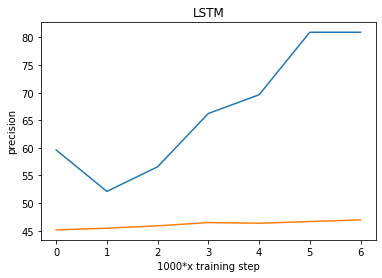

precision of the model on thevalidationdata: 46.633235931396484%
tensor([0.9995, 0.9967, 1.0000, 0.7918, 0.9998, 0.9737, 0.9980, 0.5670, 0.9999,
        0.6692, 0.6385, 0.6213, 1.0000, 0.8730, 0.9924, 0.8923, 1.0000, 0.9999,
        0.8221, 0.8359, 0.9721, 0.9910, 1.0000, 0.9998, 0.6879, 0.9102, 0.9955,
        0.9412, 0.5134, 0.7143, 0.9941, 0.6094, 0.8966, 0.9085, 0.8673, 0.9140,
        0.9999, 0.9993, 0.7830, 0.9992, 1.0000, 0.9998, 0.7269, 0.6647, 0.6350,
        0.9975, 0.9924, 0.6566, 0.9998, 0.9764, 1.0000, 0.8793, 0.9925, 0.6244,
        0.5253, 0.5243, 0.6207, 0.8729, 0.9868, 0.9910, 0.6450, 0.5206, 0.6823,
        0.5285, 0.7266, 0.8048, 1.0000, 0.9999, 0.9249, 0.6369, 0.5817, 0.5104,
        0.7830, 0.7130, 0.9546, 0.8516, 0.9445, 0.6693, 1.0000, 0.9996, 0.9988,
        0.7111, 0.5090, 0.6915, 0.9725, 0.9939, 0.9848, 0.5490, 0.9974, 0.8609,
        0.8515, 1.0000, 0.6703, 0.5682, 0.5151, 0.5307, 0.5947, 0.7108, 0.6417,
        0.5529], device='cuda:1')
current i is 89
Filte

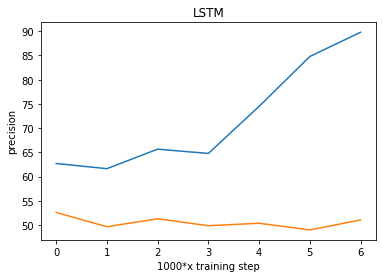

precision of the model on thevalidationdata: 52.54422378540039%
tensor([0.7361, 0.9809, 0.9920, 0.5688, 0.8336, 0.5867, 0.5077, 0.5118, 0.5956,
        0.5113, 0.5643, 0.5443, 0.5383, 0.5223, 0.5747, 0.5309, 0.9892, 0.7887,
        0.5839, 0.6295, 0.9792, 0.5436, 0.9578, 0.5165, 0.8327, 0.9889, 0.9147,
        0.6756, 0.5695, 0.8190, 0.5450, 0.5199, 0.5694, 0.5801, 0.5991, 0.6053,
        0.6197, 0.5167, 0.5799, 0.6989, 0.5908, 0.6428, 0.7887, 0.5880, 0.8392,
        0.5536, 0.6079, 0.6417, 0.5019, 0.5447, 0.5384, 0.5307, 0.8740, 0.6774,
        0.8562, 0.5536, 0.7055, 0.8874, 0.6999, 0.7194, 0.5576, 0.8728, 0.7943,
        0.6180, 0.9191, 0.8169, 0.5220, 0.5675, 0.5358, 0.9631, 0.8438, 0.6378,
        0.5050, 0.5322, 0.5780, 0.6057, 0.5652, 0.6782, 0.9471, 0.9756, 0.5613,
        0.5191, 0.5603, 0.5212, 0.6444, 0.7256, 0.5421, 0.6232, 0.5177, 0.5918,
        0.5726, 0.5403, 0.5276, 0.5225, 0.5705, 0.5364, 0.9109, 0.7500, 0.5304,
        0.5442], device='cuda:1')


In [21]:
result = LSTM_rolling_window(df_train_dict, df_valid_dict)

In [22]:
result.keys()

dict_keys(['1', '2', '4', '5', '6', '7', '8', '9', '10', '11', '12', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '79', '80', '82', '83', '84', '85', '86', '87', '88', '89'])

In [184]:
def transform_dict_to_df(result):
    result_df_dict={}
    for i in result.keys():
        valid_index_list, score, predicted, train_label_list = result[str(i)]
        first = np.array(valid_index_list)[:,0].reshape(-1,)
        second = np.array(valid_index_list)[:,1].reshape(-1,)
        third = score.cpu().reshape(-1,1).reshape(-1,)
        fourth = train_label_list.reshape(-1,)
        fifth = predicted.reshape(-1,) 
        third = np.array(third)
        fifth = np.array(fifth.cpu())
        data = np.array([first,second,third,fourth,fifth])
        data = np.transpose(data, (1,0))
        result_df_dict[str(i)] = pd.DataFrame(data=data, columns=['date','index','score','label','prediction'])
    return result_df_dict

In [312]:
result_df_dict = transform_dict_to_df(result)

In [307]:
result_df_dict['1']

,date,index,score,label,prediction
0,2013-03-14,000001.SZ,0.99999964,1.0,1
1,2013-03-15,000001.SZ,0.9999962,0.0,1
2,2013-03-18,000001.SZ,0.9614318,0.0,0
3,2013-03-14,000002.SZ,1.0,0.0,0
4,2013-03-15,000002.SZ,0.99934524,1.0,0
...,...,...,...,...,...
6993,2013-03-15,603399.SH,0.7716935,0.0,1
6994,2013-03-18,603399.SH,0.5140769,1.0,0
6995,2013-03-14,603766.SH,0.99999976,1.0,0
6996,2013-03-15,603766.SH,0.9999732,0.0,0


In [207]:
df = result_df_dict['1']

In [208]:
df['prediction'] = df['prediction'].astype('float64')
df['label'] = df['label'].astype('float64')
df['score'] = df['score'].astype('float64')

In [209]:
idx = df[df['prediction']==0].index

In [210]:
df.loc[idx,'score'] = 1-df.loc[idx,'score']

In [211]:
df

,date,index,score,label,prediction
0,2013-03-14,000001.SZ,9.999996e-01,1.0,1.0
1,2013-03-15,000001.SZ,9.999962e-01,0.0,1.0
2,2013-03-18,000001.SZ,3.856820e-02,0.0,0.0
3,2013-03-14,000002.SZ,0.000000e+00,0.0,0.0
4,2013-03-15,000002.SZ,6.547600e-04,1.0,0.0
...,...,...,...,...,...
6993,2013-03-15,603399.SH,7.716935e-01,0.0,1.0
6994,2013-03-18,603399.SH,4.859231e-01,1.0,0.0
6995,2013-03-14,603766.SH,2.400000e-07,1.0,0.0
6996,2013-03-15,603766.SH,2.680000e-05,0.0,0.0


In [201]:
#df.sort_values('score', axis=0, ascending=False).groupby(by = 'date').head(20)

In [308]:
def pre_processing(result_df_dict):
    processed = {}
    for i in result_df_dict.keys():
        print(i)
        df = result_df_dict[str(i)]
        df['prediction'] = df['prediction'].astype('float64')
        df['label'] = df['label'].astype('float64')
        df['score'] = df['score'].astype('float64')
        idx = df[df['prediction']==0].index
        df.loc[idx,'score'] = 1-df.loc[idx,'score']
        print(df)
        processed[str(i)] = df
    return processed

In [327]:
processed = pre_processing(result_df_dict)

1
            date      index         score  label  prediction
0     2013-03-14  000001.SZ  9.999996e-01    1.0         1.0
1     2013-03-15  000001.SZ  9.999962e-01    0.0         1.0
2     2013-03-18  000001.SZ  3.856820e-02    0.0         0.0
3     2013-03-14  000002.SZ  0.000000e+00    0.0         0.0
4     2013-03-15  000002.SZ  6.547600e-04    1.0         0.0
...          ...        ...           ...    ...         ...
6993  2013-03-15  603399.SH  7.716935e-01    0.0         1.0
6994  2013-03-18  603399.SH  4.859231e-01    1.0         0.0
6995  2013-03-14  603766.SH  2.400000e-07    1.0         0.0
6996  2013-03-15  603766.SH  2.680000e-05    0.0         0.0
6997  2013-03-18  603766.SH  1.100000e-06    1.0         0.0

[6998 rows x 5 columns]
2
            date      index     score  label  prediction
0     2013-04-15  000001.SZ  0.999999    0.0         1.0
1     2013-04-15  000002.SZ  1.000000    1.0         1.0
2     2013-04-15  000004.SZ  0.436643    0.0         0.0
3     2013-

            date      index         score  label  prediction
0     2014-06-06  000001.SZ  7.246074e-01    1.0         1.0
1     2014-06-09  000001.SZ  6.331918e-01    1.0         1.0
2     2014-06-06  000002.SZ  8.228530e-02    1.0         0.0
3     2014-06-09  000002.SZ  2.400000e-07    1.0         0.0
4     2014-06-06  000004.SZ  4.913700e-01    1.0         0.0
...          ...        ...           ...    ...         ...
4345  2014-06-09  603399.SH  1.246804e-02    0.0         0.0
4346  2014-06-06  603766.SH  3.549695e-02    0.0         0.0
4347  2014-06-09  603766.SH  8.311803e-01    1.0         1.0
4348  2014-06-06  603993.SH  7.136995e-02    0.0         0.0
4349  2014-06-09  603993.SH  8.381733e-01    0.0         1.0

[4350 rows x 5 columns]
18
            date      index     score  label  prediction
0     2014-07-03  000001.SZ  0.287026    0.0         0.0
1     2014-07-04  000001.SZ  0.596635    0.0         1.0
2     2014-07-07  000001.SZ  0.305428    1.0         0.0
3     2014-0

40
            date      index         score  label  prediction
0     2016-03-10  000001.SZ  1.000000e-05    0.0         0.0
1     2016-03-11  000001.SZ  4.200000e-06    0.0         0.0
2     2016-03-14  000001.SZ  1.696942e-01    1.0         0.0
3     2016-03-10  000004.SZ  2.400000e-07    1.0         0.0
4     2016-03-11  000004.SZ  5.978400e-03    1.0         0.0
...          ...        ...           ...    ...         ...
7169  2016-03-11  603997.SH  1.013000e-05    1.0         0.0
7170  2016-03-14  603997.SH  8.491075e-01    0.0         1.0
7171  2016-03-10  603998.SH  1.479400e-04    0.0         0.0
7172  2016-03-11  603998.SH  6.100000e-06    1.0         0.0
7173  2016-03-14  603998.SH  9.998469e-01    0.0         1.0

[7174 rows x 5 columns]
41
            date      index     score  label  prediction
0     2016-04-08  000001.SZ  0.462193    1.0         0.0
1     2016-04-11  000001.SZ  0.718444    0.0         1.0
2     2016-04-08  000005.SZ  0.656197    0.0         1.0
3     201

            date      index     score  label  prediction
0     2017-09-21  000001.SZ  0.998891    0.0         1.0
1     2017-09-22  000001.SZ  0.999769    0.0         1.0
2     2017-09-25  000001.SZ  0.000012    0.0         0.0
3     2017-09-21  000002.SZ  0.034588    0.0         0.0
4     2017-09-22  000002.SZ  0.004783    0.0         0.0
...          ...        ...       ...    ...         ...
8565  2017-09-22  603998.SH  0.324142    1.0         0.0
8566  2017-09-25  603998.SH  0.939592    0.0         1.0
8567  2017-09-21  603999.SH  0.541269    0.0         1.0
8568  2017-09-22  603999.SH  0.552091    0.0         1.0
8569  2017-09-25  603999.SH  0.366968    0.0         0.0

[8570 rows x 5 columns]
61
            date      index     score  label  prediction
0     2017-10-19  000001.SZ  0.514974    0.0         1.0
1     2017-10-20  000001.SZ  0.513569    0.0         1.0
2     2017-10-23  000001.SZ  0.121122    1.0         0.0
3     2017-10-19  000002.SZ  0.000000    1.0         0.0
4  

            date      index     score  label  prediction
0     2019-04-04  000001.SZ  0.078346    1.0         0.0
1     2019-04-08  000001.SZ  0.287528    0.0         0.0
2     2019-04-04  000002.SZ  0.759313    0.0         1.0
3     2019-04-08  000002.SZ  0.632513    1.0         1.0
4     2019-04-04  000005.SZ  0.527332    0.0         1.0
...          ...        ...       ...    ...         ...
6863  2019-04-08  603997.SH  0.405432    1.0         0.0
6864  2019-04-04  603998.SH  0.854884    1.0         1.0
6865  2019-04-08  603998.SH  0.669432    1.0         1.0
6866  2019-04-04  603999.SH  0.993826    0.0         1.0
6867  2019-04-08  603999.SH  0.742298    1.0         1.0

[6868 rows x 5 columns]
82
             date      index         score  label  prediction
0      2019-05-30  000001.SZ  2.150000e-06    1.0         0.0
1      2019-05-31  000001.SZ  6.973844e-01    0.0         1.0
2      2019-06-03  000001.SZ  1.000000e+00    1.0         1.0
3      2019-05-30  000002.SZ  1.169400e-

In [331]:
processed

{'1':             date      index         score  label  prediction
 0     2013-03-14  000001.SZ  9.999996e-01    1.0         1.0
 1     2013-03-15  000001.SZ  9.999962e-01    0.0         1.0
 2     2013-03-18  000001.SZ  3.856820e-02    0.0         0.0
 3     2013-03-14  000002.SZ  0.000000e+00    0.0         0.0
 4     2013-03-15  000002.SZ  6.547600e-04    1.0         0.0
 ...          ...        ...           ...    ...         ...
 6993  2013-03-15  603399.SH  7.716935e-01    0.0         1.0
 6994  2013-03-18  603399.SH  4.859231e-01    1.0         0.0
 6995  2013-03-14  603766.SH  2.400000e-07    1.0         0.0
 6996  2013-03-15  603766.SH  2.680000e-05    0.0         0.0
 6997  2013-03-18  603766.SH  1.100000e-06    1.0         0.0
 
 [6998 rows x 5 columns],
 '2':             date      index     score  label  prediction
 0     2013-04-15  000001.SZ  0.999999    0.0         1.0
 1     2013-04-15  000002.SZ  1.000000    1.0         1.0
 2     2013-04-15  000004.SZ  0.436643    0.

In [325]:
def sort_top_k(result_df_dict,k):
    top_k_df={}
    for i in result_df_dict.keys():
        #print(i)
        temp = result_df_dict[str(i)].sort_values('score', axis=0, ascending=False).groupby(by = 'date').head(k)
        #print(temp)
        top_k_df[str(i)] = temp
    return top_k_df

In [318]:
def precision_top_k(head):
    pre=[]
    for i in head.keys():
        pre.append(sum(head[str(i)]['label']*head[str(i)]['prediction'])/sum(head[str(i)]['prediction']))
    return pre

In [330]:
def mult_k(processed,k):
    pre_dict={}
    for i in k:
        print(i)
        head = sort_top_k(processed,i)
        pre_dict[str(i)]=precision_top_k(head)
    for i in k:
        plt.plot(pre_dict[str(i)],label='top'+str(i))
        plt.legend()
    plt.ylabel('precision')
    plt.show()
    return pre_dict

10
20
40
80
160
320
640
1280


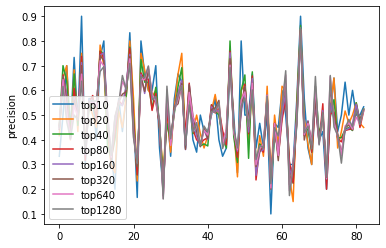

In [347]:
precision_diction = mult_k(processed,[10,20,40,80,160,320,640,1280])

In [348]:
for i in precision_diction.keys():
    print('top'+str(i),'mean precision:',sum(precision_diction[str(i)])/len(precision_diction[str(i)]))

top10 mean precision: 0.49839357429718867
top20 mean precision: 0.4950803212851405
top40 mean precision: 0.4916164658634539
top80 mean precision: 0.48687248995983967
top160 mean precision: 0.48980923694779116
top320 mean precision: 0.4912648086564058
top640 mean precision: 0.4913228274856037
top1280 mean precision: 0.48906354336843144
